In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import os
os.chdir("/content/sample_data")
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar xvzf ta-lib-0.4.0-src.tar.gz
os.chdir('ta-lib') # Can't use !cd in co-lab
!./configure --prefix=/usr
!make
!make install
os.chdir('../')
!pip install TA-Lib
!pip install pandas_ta
!pip install bt

In [ ]:
!pip install -U vectorbt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.2 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.41.1
    Uninstalling llvmlite-0.41.1:
      Successfully uninstalled llvmlite-0.41.1
  Attempting uninstall: numba
    Found existing installation: numba 0.58.1
    Uninstalling numba-0.58.1:
      Successfully uninstalled numba-0.58.1


In [ ]:
# prompt: load a dataset from a csv from google drive and then filter duplicates.Finally run random forest for classification .

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import joblib
# Load the data from a CSV file on Google Drive.
from google.colab import drive
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import talib
import bt
from collections import defaultdict
import pandas_ta as ta
import vectorbt as vbt

In [ ]:
os.chdir("/content/drive/MyDrive/stockdt/")

## Download data


In [ ]:
import yfinance as yf
import pandas as pd
equity_details = pd.read_csv('EQUITY_L.csv') # All Details for NSE stocks : Symbol is the required field
for name in equity_details.SYMBOL:
    try:
        data = yf.download(f'{name}.NS',period='10y')
        data.to_csv(f'./Data/{name}.csv') # Data will be stored in data folder
    except Exception as e:
        print(f'{name} ===> {e}')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

##Prepare data for training

In [ ]:
class Dataset:
    def __init__(self):
        self.df = None
    def append(self, df):
        if self.df is None:
            self.df = df
        else:
            self.df = pd.concat([self.df,df], ignore_index=True)

In [ ]:
from datetime import datetime, timedelta
import numpy as np
today_date = datetime.now()- timedelta(days=7)
stocks_to_buy =[]
dt=Dataset()
def GoldenCrossverSignal(name):
    path = f'./Data/{name}.csv'
    data = pd.read_csv(path, parse_dates=['Date'], ) #index_col='Date'
    data['Date'] = pd.to_datetime(data['Date'])

    data['Prev_Close'] = data.Close.shift(1)
    data['20_SMA'] = data.Prev_Close.rolling(window=20, min_periods=1).mean()
    data['50_SMA'] = data.Prev_Close.rolling(window=50, min_periods=1).mean()
    data['100_SMA'] = data.Prev_Close.rolling(window=100, min_periods=1).mean()
    data['20_SMA_diff_7'] =  (data['20_SMA'] - data['20_SMA'].shift(7))/data['20_SMA'].shift(7)
    data['20_SMA_diff_2'] =  (data['20_SMA'] - data['20_SMA'].shift(2))/data['20_SMA'].shift(2)
    data['20_SMA_diff_14'] =  (data['20_SMA'] - data['20_SMA'].shift(14))/data['20_SMA'].shift(14)
    data['50_SMA_diff_14'] = (data['50_SMA'] - data['50_SMA'].shift(14)) /data['50_SMA'].shift(14)
    data['50_SMA_diff_7'] = (data['50_SMA'] - data['50_SMA'].shift(7)) /data['50_SMA'].shift(7)
    data['50_SMA_diff_2'] = (data['50_SMA'] - data['50_SMA'].shift(2)) /data['50_SMA'].shift(2)

    data['100_SMA_diff_14'] = (data['100_SMA'] - data['100_SMA'].shift(14)) /data['100_SMA'].shift(14)
    data['100_SMA_diff_7'] = (data['100_SMA'] - data['100_SMA'].shift(7)) /data['100_SMA'].shift(7)
    data['100_SMA_diff_2'] = (data['100_SMA'] - data['100_SMA'].shift(2)) /data['100_SMA'].shift(2)

    data['50_SMA_diff'] =  data['50_SMA'].shift(-14) - data['50_SMA']

    # data = data.iloc[-x:y]
    data['Signal'] = 0
    data['Signal'] = np.where((data['50_SMA_diff'] > 0), 1, 0)
    data['Position'] = data.Signal.diff()

    prev=0
    data['AlreadyBought'] =0
    bought = 0
    for i , val in data['Position'].items():
        # print(i,val)
        data.at[i,'AlreadyBought'] = bought
        if val ==1 or val == -1:
            diff = i-prev
            mid = diff//2
            if mid > prev and  mid < i:   data.at[mid,'Position'] = 2
            prev = i
        if val == 1:
            bought = 1
        if val == -1:
            bought = 0


    df_pos = data[(data['Position'] == 1) | (data['Position'] == -1) | (data['Position'] == 2)].copy()
    dt.append(df_pos)
    # df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x == 1 else 'Sell')

    # print(df_pos.columns)
    # Filter the DataFrame based on the conditions



    return  df_pos,data,name

stocks = pd.read_csv('./EQUITY_L.csv')
scripts = stocks["SYMBOL"]
# scripts=["IEX"]
for stock in tqdm(scripts[:]):
    filtered_df, data, name = GoldenCrossverSignal(stock)

100%|██████████| 1935/1935 [07:03<00:00,  4.57it/s]


In [ ]:
dt.df.to_csv("dataset_stock.csv",index=None)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/stockdt/dataset_stock.csv')
df = df.drop_duplicates()
df = df.drop([ "Open", "High", "Low", "Adj Close", "20_SMA", "50_SMA","50_SMA_diff", "Signal", "Close", "Volume", "Prev_Close", "Date"], axis=1)
df.describe()

,100_SMA,20_SMA_diff_7,20_SMA_diff_2,20_SMA_diff_14,50_SMA_diff_14,50_SMA_diff_7,50_SMA_diff_2,100_SMA_diff_14,100_SMA_diff_7,100_SMA_diff_2,Position,AlreadyBought
count,70418.000000,68548.000000,69437.000000,67577.000000,67577.000000,68548.000000,69437.000000,67577.000000,68548.000000,69437.000000,70418.000000,70418.000000
mean,473.939348,-0.000933,-0.000252,-0.000125,0.001532,0.000074,-0.000009,0.005079,0.001927,0.000491,0.090943,0.499006
std,2212.688945,0.043767,0.027683,0.070867,0.050147,0.025939,0.012760,0.041835,0.021347,0.008279,1.062149,0.500003
min,0.050000,-0.842138,-0.241005,-0.843357,-0.946117,-0.897264,-0.712998,-0.643458,-0.473612,-0.457290,-1.000000,0.000000
25%,33.912250,-0.018967,-0.005831,-0.033034,-0.023264,-0.011468,-0.003328,-0.017591,-0.008835,-0.002585,-1.000000,0.000000
50%,107.204500,-0.001832,-0.000496,-0.003330,0.000351,0.000050,0.000000,0.002895,0.001231,0.000326,1.000000,0.000000
75%,351.695955,0.015390,0.004812,0.027560,0.026005,0.011986,0.003339,0.026305,0.012519,0.003519,1.000000,1.000000
max,110515.546641,5.057878,4.827191,4.958468,1.898169,1.891808,1.864974,0.827305,0.840289,0.871198,2.000000,1.000000


In [ ]:
# prompt: drop all the rows where any value is Na

df = df.dropna()


In [ ]:

# Split the data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(df.drop('Position', axis=1), df['Position'], test_size=0.25,  random_state=42)
# Instantiate the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the scaler on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the scaled training data
clf.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
y_pred = clf.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# Save the model to a file.
os.makedirs('models', exist_ok=True)
# model_path = os.path.join('models', 'random_forest_classifier.pkl')
# classifier.save(model_path)

Accuracy: 0.97


In [ ]:
# Get the confidence scores for each prediction
confidence_scores = clf.predict_proba(X_test_scaled)

# Print the confidence scores for the first few predictions
for i in range( min(10,len(X_test))):
    print(f"Prediction {i + 1}: {y_pred[i]} (Class {y_pred[i]}), Confidence Scores: {confidence_scores[i]}")


Prediction 1: 1.0 (Class 1.0), Confidence Scores: [0.   0.99 0.01]
Prediction 2: 1.0 (Class 1.0), Confidence Scores: [0.   0.98 0.02]
Prediction 3: 1.0 (Class 1.0), Confidence Scores: [0. 1. 0.]
Prediction 4: 1.0 (Class 1.0), Confidence Scores: [0.   0.98 0.02]
Prediction 5: 1.0 (Class 1.0), Confidence Scores: [0.02 0.95 0.03]
Prediction 6: -1.0 (Class -1.0), Confidence Scores: [1. 0. 0.]
Prediction 7: -1.0 (Class -1.0), Confidence Scores: [1. 0. 0.]
Prediction 8: -1.0 (Class -1.0), Confidence Scores: [0.97 0.   0.03]
Prediction 9: 1.0 (Class 1.0), Confidence Scores: [0. 1. 0.]
Prediction 10: 1.0 (Class 1.0), Confidence Scores: [0. 1. 0.]


In [ ]:
model_filename = './random_forest_model.joblib'
joblib.dump(clf, model_filename)
joblib.dump(scaler, "./scaler.joblib")

NameError: name 'clf' is not defined

# Backtesting

## CLassical backtesting

In [ ]:

# Name, Entry TIme, Entry PRice, QTY, Exit Time, Exit Price

class Backtest:
    def __init__(self):
        self.columns = ['Equity Name', 'Trade', 'Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'Quantity', 'Position Size', 'PNL', '% PNL']
        self.backtesting = pd.DataFrame(columns=self.columns)

    def buy(self, equity_name, entry_time, entry_price, qty):
        self.trade_log = dict(zip(self.columns, [None] * len(self.columns)))
        self.trade_log['Trade'] = 'Long Open'
        self.trade_log['Quantity'] = qty
        self.trade_log['Position Size'] = round(self.trade_log['Quantity'] * entry_price, 3)
        self.trade_log['Equity Name'] = equity_name
        self.trade_log['Entry Time'] = entry_time
        self.trade_log['Entry Price'] = round(entry_price, 2)

    def sell(self, exit_time, exit_price, exit_type, charge):
        self.trade_log['Trade'] = 'Long Closed'
        self.trade_log['Exit Time'] = exit_time
        self.trade_log['Exit Price'] = round(exit_price, 2)
        self.trade_log['Exit Type'] = exit_type
        self.trade_log['PNL'] = round((self.trade_log['Exit Price'] - self.trade_log['Entry Price']) * self.trade_log['Quantity'] - charge, 3)
        self.trade_log['% PNL'] = round((self.trade_log['PNL'] / self.trade_log['Position Size']) * 100, 3)
        self.trade_log['Holding Period'] = exit_time - self.trade_log['Entry Time']
        # self.backtesting = self.backtesting.append(self.trade_log, ignore_index=True)
        self.backtesting.loc[len(self.backtesting)] = self.trade_log
    def stats(self):
        df = self.backtesting
        parameters = ['Total Trade Scripts', 'Total Trade', 'PNL',  'Winners', 'Losers', 'Win Ratio','Total Profit', 'Total Loss', 'Average Loss per Trade', 'Average Profit per Trade', 'Average PNL Per Trade', 'Risk Reward']
        total_traded_scripts = len(df['Equity Name'].unique())
        total_trade = len(df.index)
        pnl = df.PNL.sum()
        winners = len(df[df.PNL > 0])
        loosers = len(df[df.PNL <= 0])
        win_ratio = str(round((winners/total_trade) * 100, 2)) + '%'
        total_profit = round(df[df.PNL > 0].PNL.sum(), 2)
        total_loss  = round(df[df.PNL <= 0].PNL.sum(), 2)
        average_loss_per_trade = round(total_loss/loosers, 2)
        average_profit_per_trade = round(total_profit/winners, 2)
        average_pnl_per_trade = round(pnl/total_trade, 2)
        risk_reward = f'1:{-1 * round(average_profit_per_trade/average_loss_per_trade, 2)}'
        data_points = [total_traded_scripts,total_trade,pnl,winners, loosers, win_ratio, total_profit, total_loss, average_loss_per_trade, average_profit_per_trade, average_pnl_per_trade, risk_reward]
        data = list(zip(parameters,data_points ))
        print(tabulate(data, ['Parameters', 'Values'], tablefmt='psql'))


In [ ]:
model_filename = 'random_forest_model.joblib'
clf = joblib.load(model_filename)
scaler = joblib.load("./scaler.joblib")

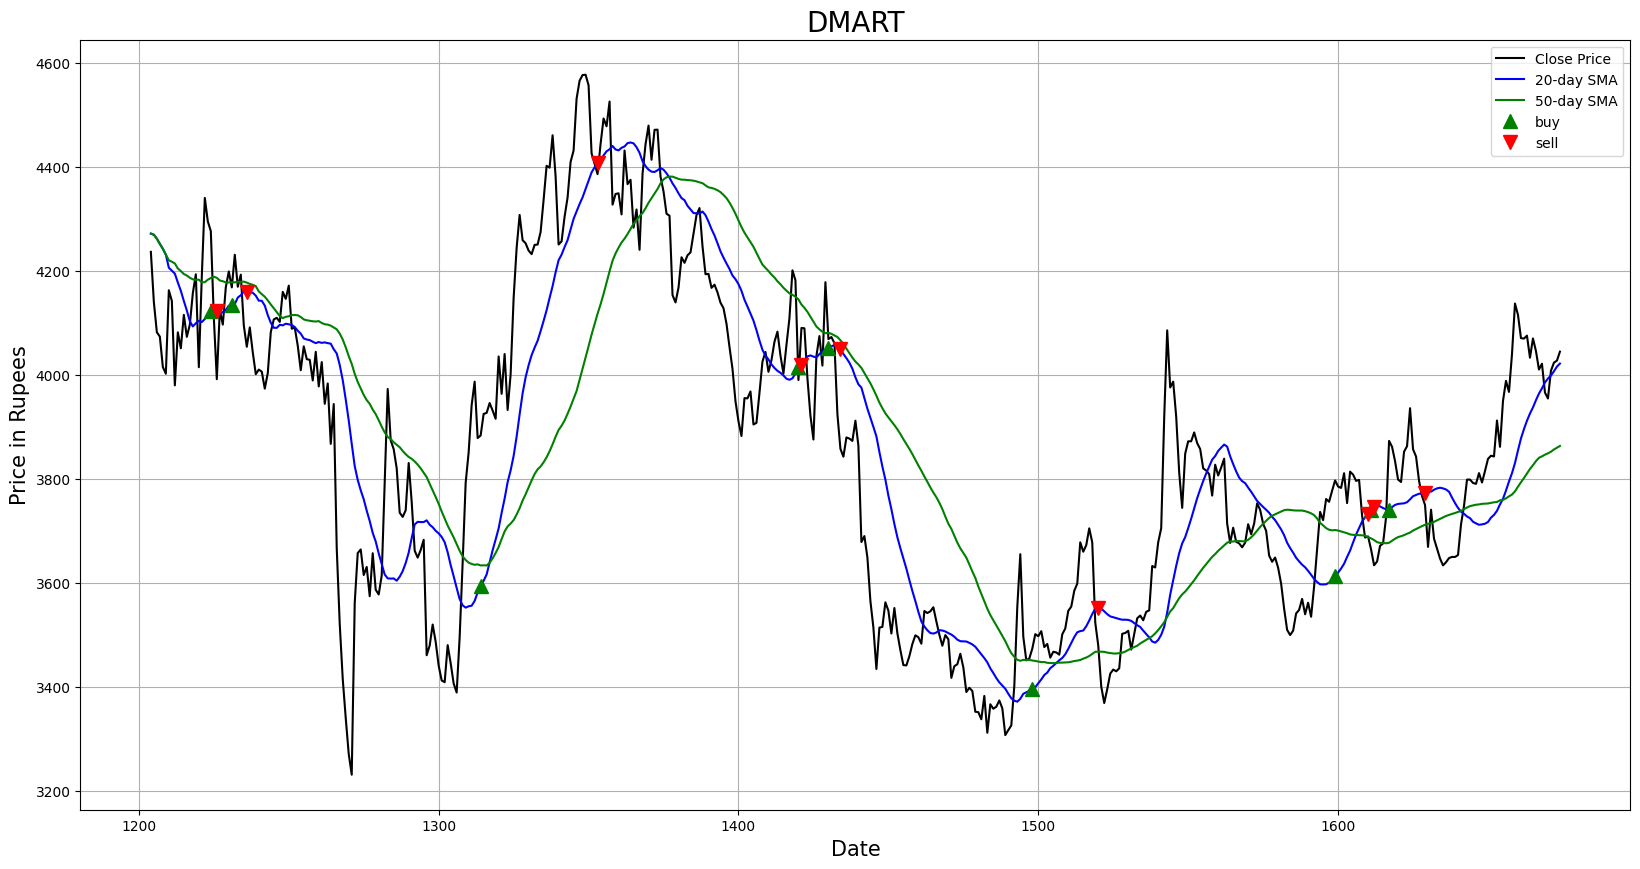

+------+---------+------------+
|      |   Close |   Position |
|------+---------+------------|
| 1981 | 3856.2  |          0 |
| 1982 | 3824.6  |          0 |
| 1983 | 3814.9  |          0 |
| 1984 | 3779    |          0 |
| 1985 | 3743.45 |          0 |
| 1986 | 3760.55 |          0 |
| 1987 | 3770.35 |          0 |
| 1988 | 3694.95 |          0 |
| 1989 | 3733.75 |          0 |
| 1990 | 3817.8  |          0 |
| 1991 | 3813.1  |          0 |
| 1992 | 3784.2  |          0 |
| 1993 | 3793.9  |          0 |
| 1994 | 3719.4  |          0 |
| 1995 | 3586.4  |          0 |
| 1996 | 3563.8  |          0 |
| 1997 | 3401.65 |          0 |
| 1998 | 3520.75 |          0 |
| 1999 | 3554.2  |          0 |
| 2000 | 3546.15 |          0 |
| 2001 | 3544.4  |          0 |
| 2002 | 3524.35 |          0 |
| 2003 | 3484.9  |          0 |
| 2004 | 3599.95 |          0 |
| 2005 | 3632.6  |          0 |
| 2006 | 3620.95 |          0 |
| 2007 | 3599.15 |          0 |
| 2008 | 3643    |          0 |
| 2009 |

In [ ]:
from datetime import datetime, timedelta
import numpy as np
today_date = datetime.now()- timedelta(days=7)
stocks_to_buy =[]
# dt=Dataset()
def GoldenCrossverSignal(name,datapoint):
    path = f'./Data/{name}.csv'
    data = pd.read_csv(path, parse_dates=['Date'], ) #index_col='Date'
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.iloc[-datapoint:]
    data['Prev_Close'] = data.Close.shift(1)
    data['20_SMA'] = data.Prev_Close.rolling(window=20, min_periods=1).mean()
    data['50_SMA'] = data.Prev_Close.rolling(window=50, min_periods=1).mean()
    data['100_SMA'] = data.Prev_Close.rolling(window=100, min_periods=1).mean()
    data['7_SMA'] = data.Prev_Close.rolling(window=7, min_periods=1).mean()
    data['20_SMA_diff_7'] =  (data['20_SMA'] - data['20_SMA'].shift(7))/data['20_SMA'].shift(7)
    data['20_SMA_diff_2'] =  (data['20_SMA'] - data['20_SMA'].shift(2))/data['20_SMA'].shift(2)
    data['20_SMA_diff_14'] =  (data['20_SMA'] - data['20_SMA'].shift(14))/data['20_SMA'].shift(14)
    data['50_SMA_diff_14'] = (data['50_SMA'] - data['50_SMA'].shift(14)) /data['50_SMA'].shift(14)
    data['50_SMA_diff_7'] = (data['50_SMA'] - data['50_SMA'].shift(7)) /data['50_SMA'].shift(7)
    data['50_SMA_diff_2'] = (data['50_SMA'] - data['50_SMA'].shift(2)) /data['50_SMA'].shift(2)

    data['100_SMA_diff_14'] = (data['100_SMA'] - data['100_SMA'].shift(14)) /data['100_SMA'].shift(14)
    data['100_SMA_diff_7'] = (data['100_SMA'] - data['100_SMA'].shift(7)) /data['100_SMA'].shift(7)
    data['100_SMA_diff_2'] = (data['100_SMA'] - data['100_SMA'].shift(2)) /data['100_SMA'].shift(2)

    data['50_SMA_diff'] =  data['50_SMA'].shift(-14) - data['50_SMA']
    data['AlreadyBought'] =0
    bought = 0
    # data = data.iloc[-x:y]
    data['Signal'] = 0
    # data['Signal'] = np.where( (data['20_SMA_diff_7'] < 0 ) & (data['Prev_Close'] > data['20_SMA']) , 1, 0)
    for index, row in data.iterrows():
      if bought :
        if row['Prev_Close'] <= row['20_SMA']:
          bought=0
      else:
        if row['20_SMA_diff_7'] > 0  and row['50_SMA_diff_7'] < 0 and row['Prev_Close'] >= row['50_SMA']:
          bought = 1

      data.loc[index,"Signal"] = bought

    # data['Signal'] = np.where(data['20_SMA'] > data['50_SMA'], 1, 0)
    data['Position'] = data.Signal.diff()
    prev=0
    for val in ["Predict", "sell_prob", "buy_proba", "DoNothingProba"] :
      data[val] = 0.0

    data = data.dropna()
    feature_names = ['100_SMA', '20_SMA_diff_7', '20_SMA_diff_2', '20_SMA_diff_14',
       '50_SMA_diff_14', '50_SMA_diff_7', '50_SMA_diff_2', '100_SMA_diff_14',
       '100_SMA_diff_7', '100_SMA_diff_2', 'AlreadyBought']
    new_df = data[feature_names]

    # for index, row in new_df.iterrows():
    #   # Assuming you only have features in your DataFrame
    #   # Replace 'row' with the actual name of your row variable

    #   # features = row.values.reshape(1, -1)  # Reshape to a 2D array for prediction
    #   row['AlreadyBought'] = bought
    #   nd = pd.DataFrame(columns=feature_names)
    #   nd.loc[0] = row.values
    #   # Scale the features using the scaler
    #   features_scaled = scaler.transform(nd)

    #   # Make prediction
    #   prediction=0
    #   sell,buy,hold = clf.predict_proba(features_scaled)[0]
    #   if buy > 0.5 :
    #     bought = 1
    #     prediction=1
    #   if sell > 0.90:
    #     prediction=-1
    #     bought = 0
    #   data.loc[index,["Predict", "sell_prob", "buy_proba", "DoNothingProba"]] = [prediction,sell,buy,hold]

    # # data.to_csv(f"{name}_out.csv")
    # # dt.append(df_pos)
    # df_pos = data[(data['Predict'] == 1) | (data['Predict'] == -1)].copy()
    # df_pos['Predict'] = df_pos['Predict'].apply(lambda x: 'Buy' if x == 1 else 'Sell')
    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages
    data['Close'].plot(color = 'k', label= 'Close Price')
    data['20_SMA'].plot(color = 'b',label = '20-day SMA')
    data['50_SMA'].plot(color = 'g', label = '50-day SMA')
    # data['100_SMA'].plot(color = 'y', label = '100-day SMA')
    # data['7_SMA'].plot(color = 'orange', label = '50-day SMA')

    # plot ‘buy’ signals
    plt.plot(data[data['Position'] == 1].index,
             data['20_SMA'][data['Position'] == 1],
             '^', markersize = 10, color = 'g', label = 'buy')
    # plot ‘sell’ signals
    plt.plot(data[data['Position'] == -1].index,
             data['20_SMA'][data['Position'] == -1],
             'v', markersize = 10, color = 'r', label = 'sell')
    # plt.plot(data[data['50_SMA_diff_7'] > 0].index,
    #          data['50_SMA'][data['50_SMA_diff_7'] > 0],
    #          'o', markersize = 4, color = 'r', label = 'sell')

    # plt.plot(data[data['20_SMA_diff_7'] > 0].index,
    #          data['20_SMA'][data['20_SMA_diff_7'] > 0],
    #          'o', markersize = 4, color = 'r', label = 'sell')

    # plt.plot(data[data['Predict'] == 1].index,
    #          data['20_SMA'][data['Predict'] == 1],
    #          '^', markersize = 15, color = 'y', label = 'buy')
    # # plot ‘sell’ signals
    # plt.plot(data[data['Predict'] == -1].index,
    #          data['20_SMA'][data['Predict'] == -1],
            #  'v', markersize = 15, color = 'orange', label = 'sell')
    plt.ylabel('Price in Rupees', fontsize = 15 )
    plt.xlabel('Date', fontsize = 15 )
    plt.title(name, fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show()
    print(tabulate(df_pos[['Close', 'Position']], headers = 'keys', tablefmt = 'psql'))


    # print(df_pos.columns)
    # Filter the DataFrame based on the conditions



    return  data
sty='DMART'
df_pos = GoldenCrossverSignal(sty,500)
# df_pos

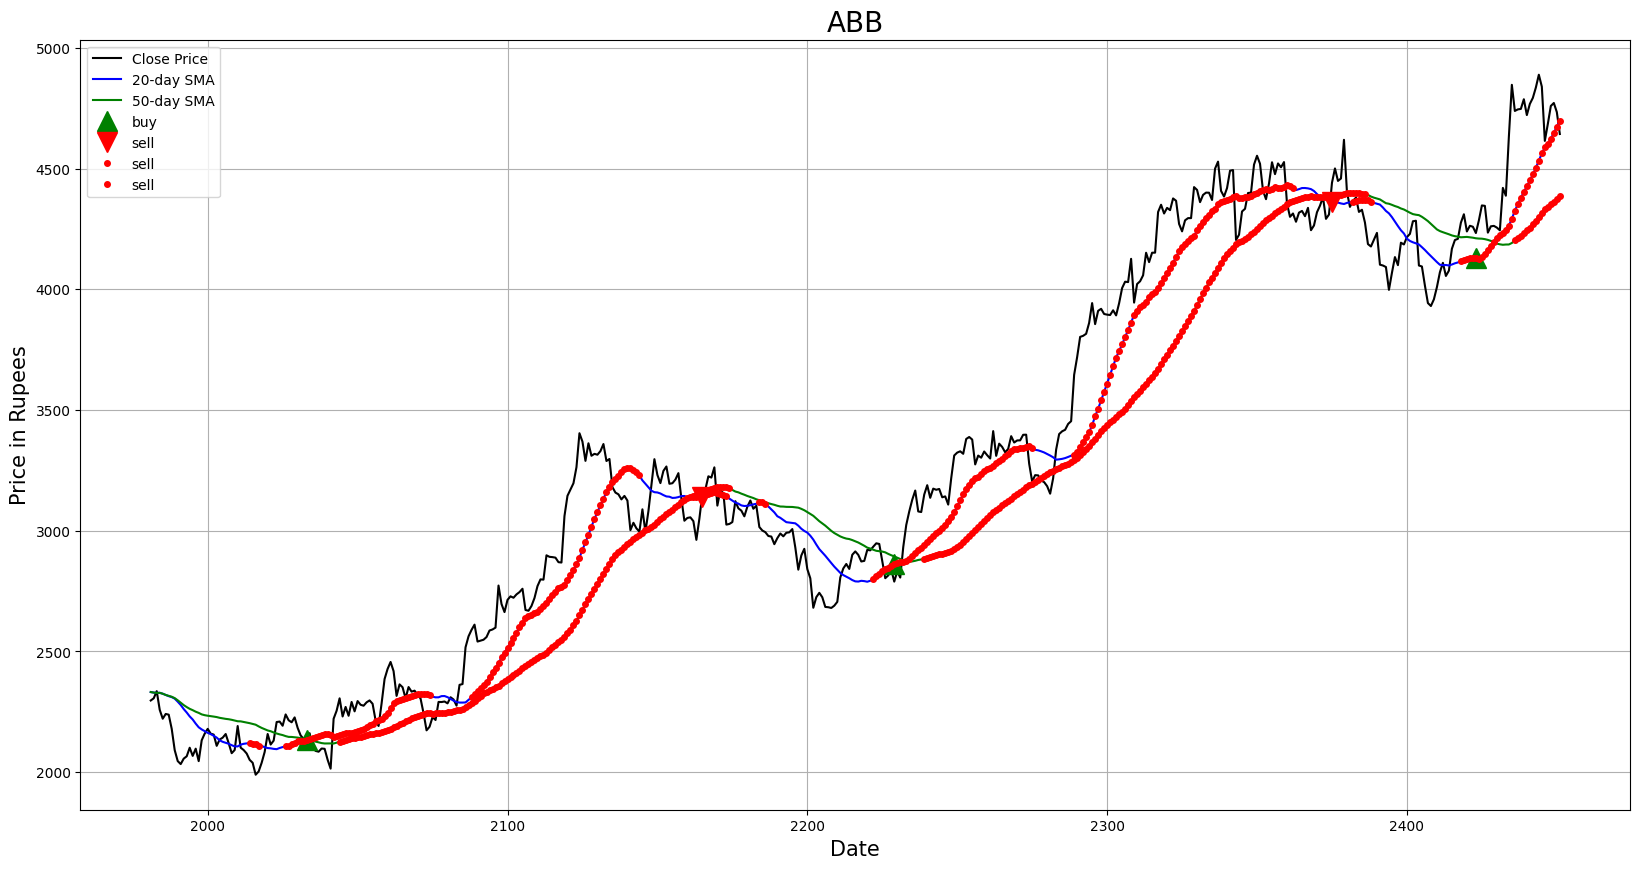

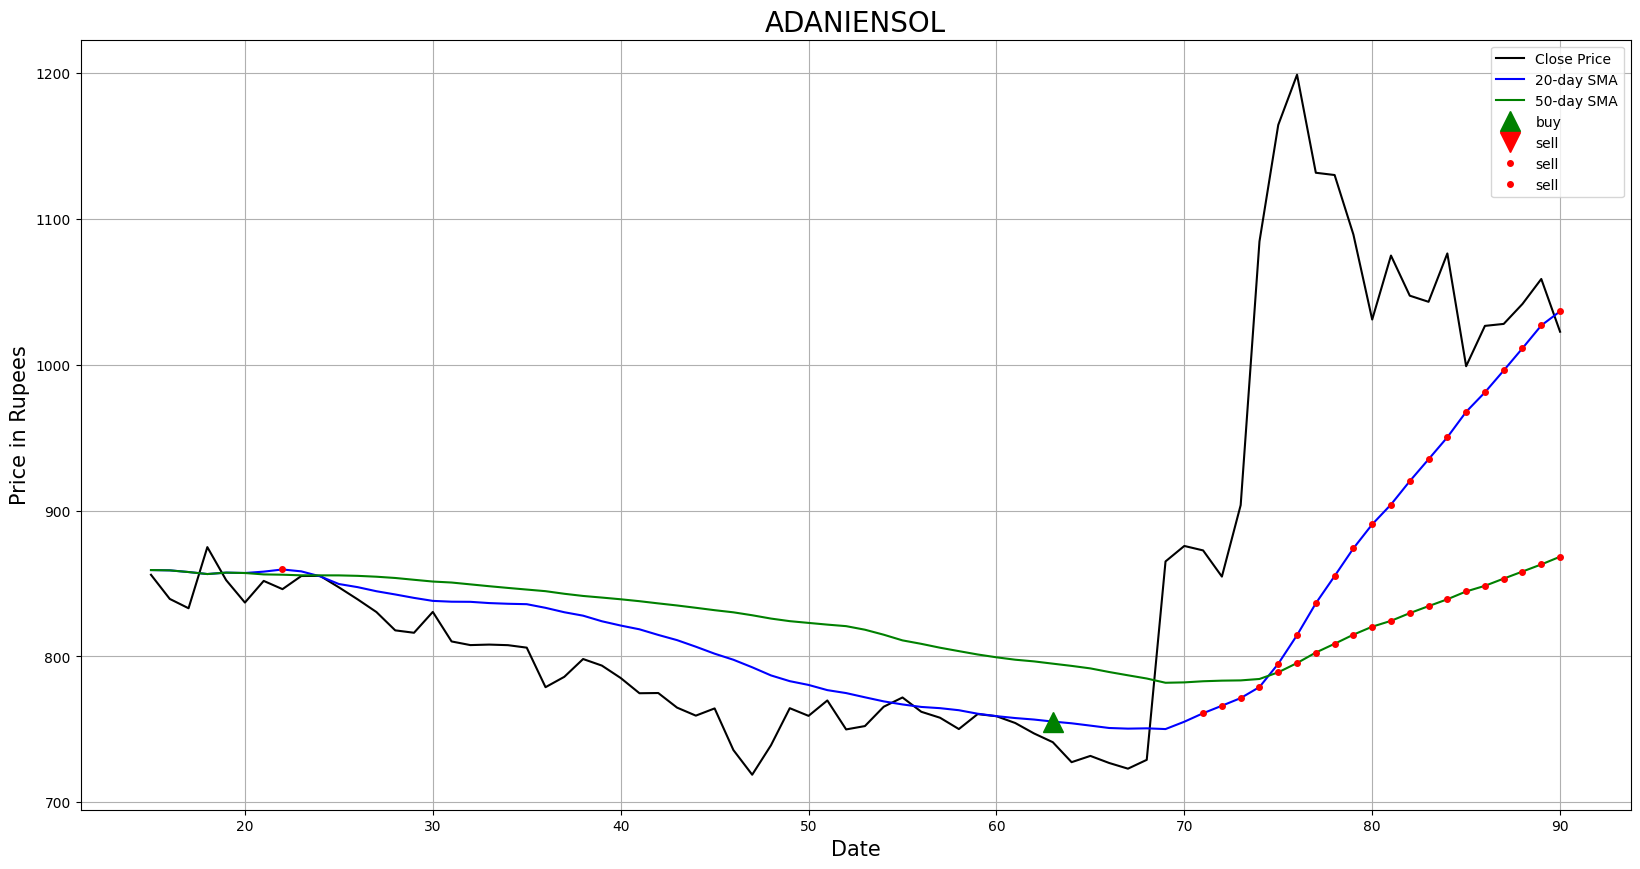

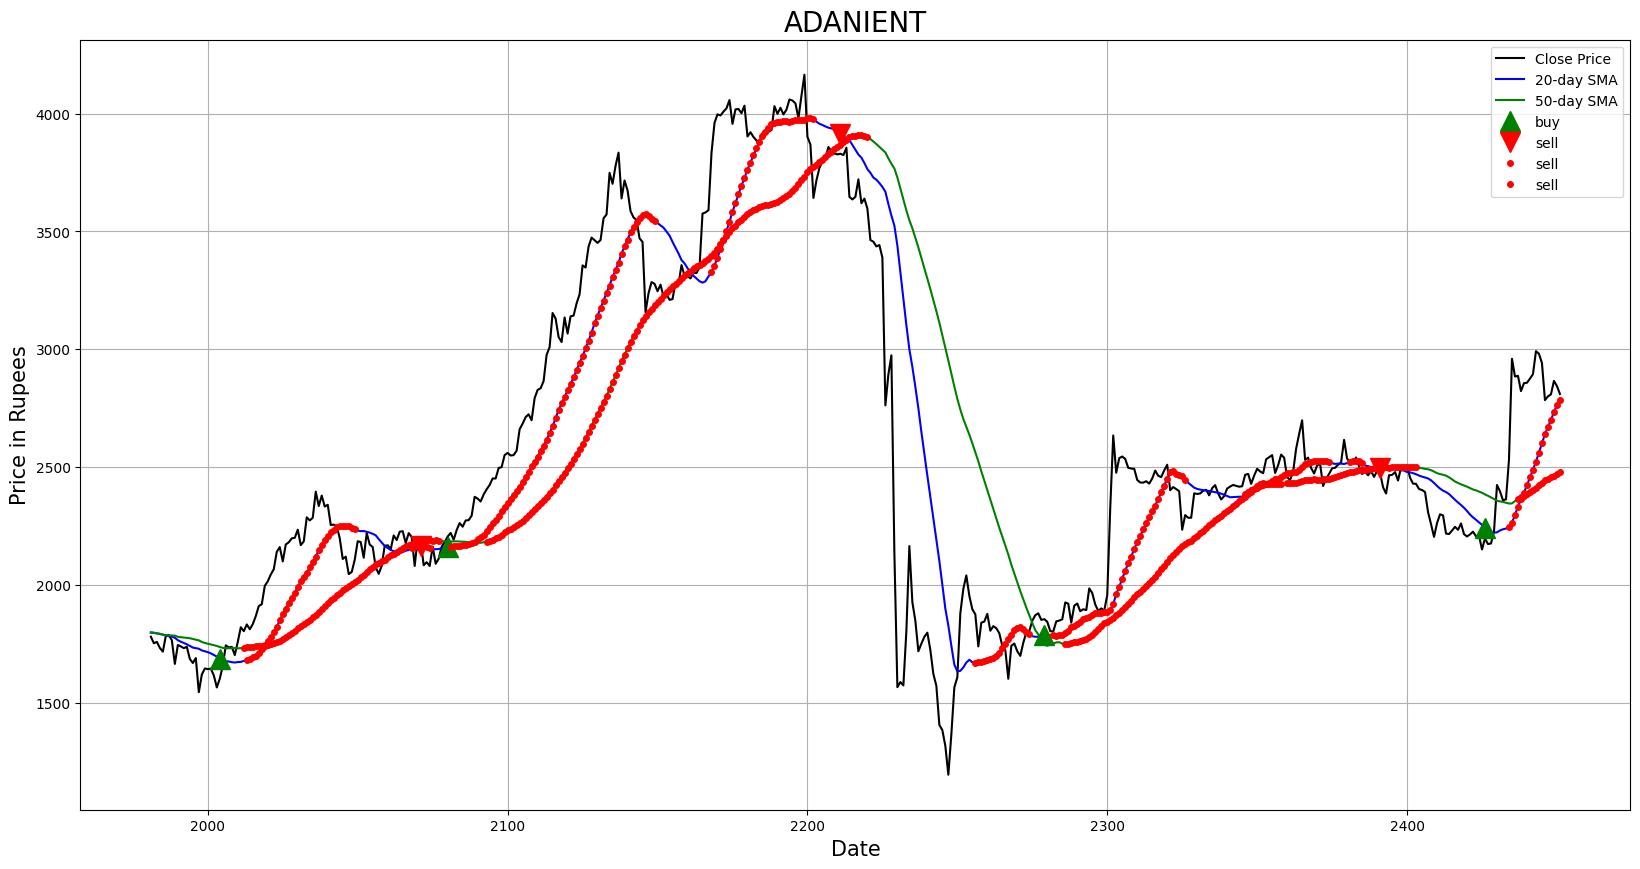

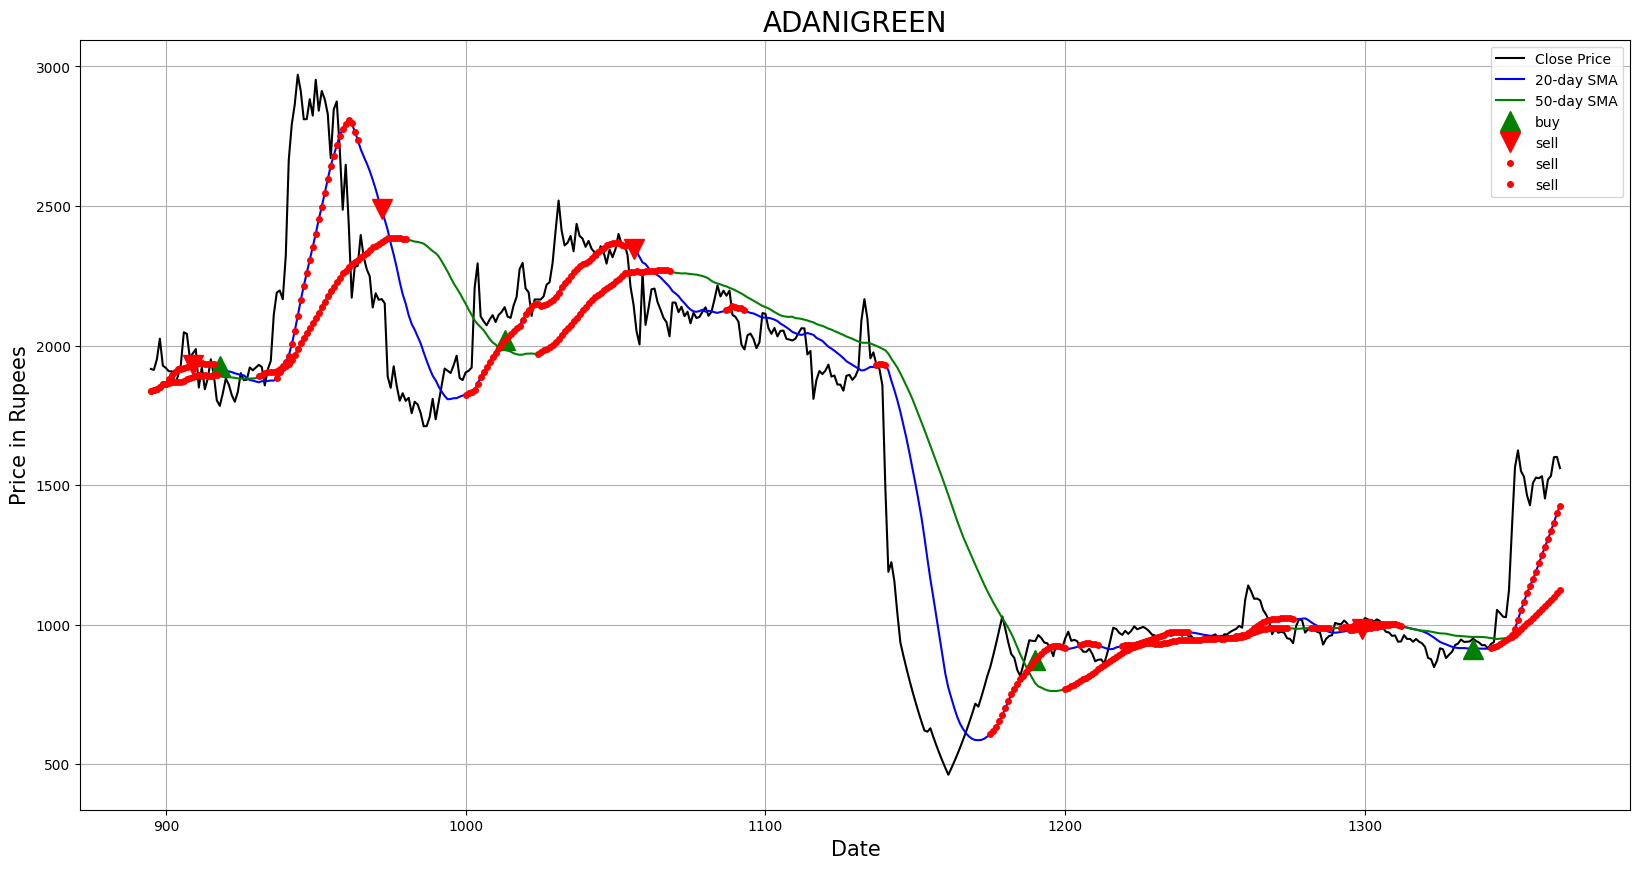

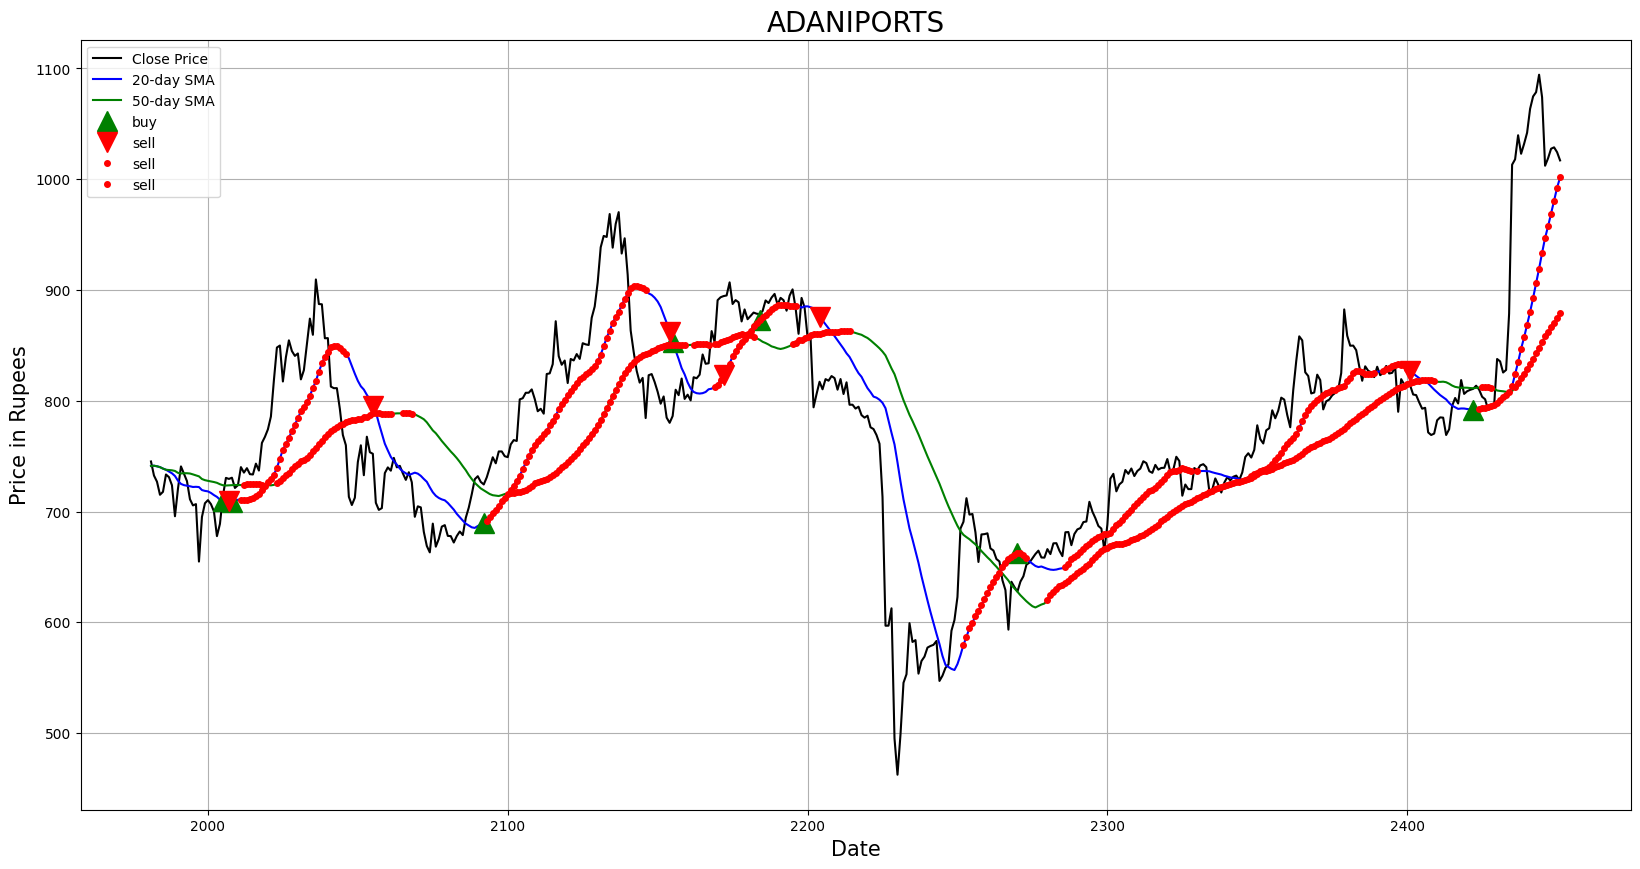

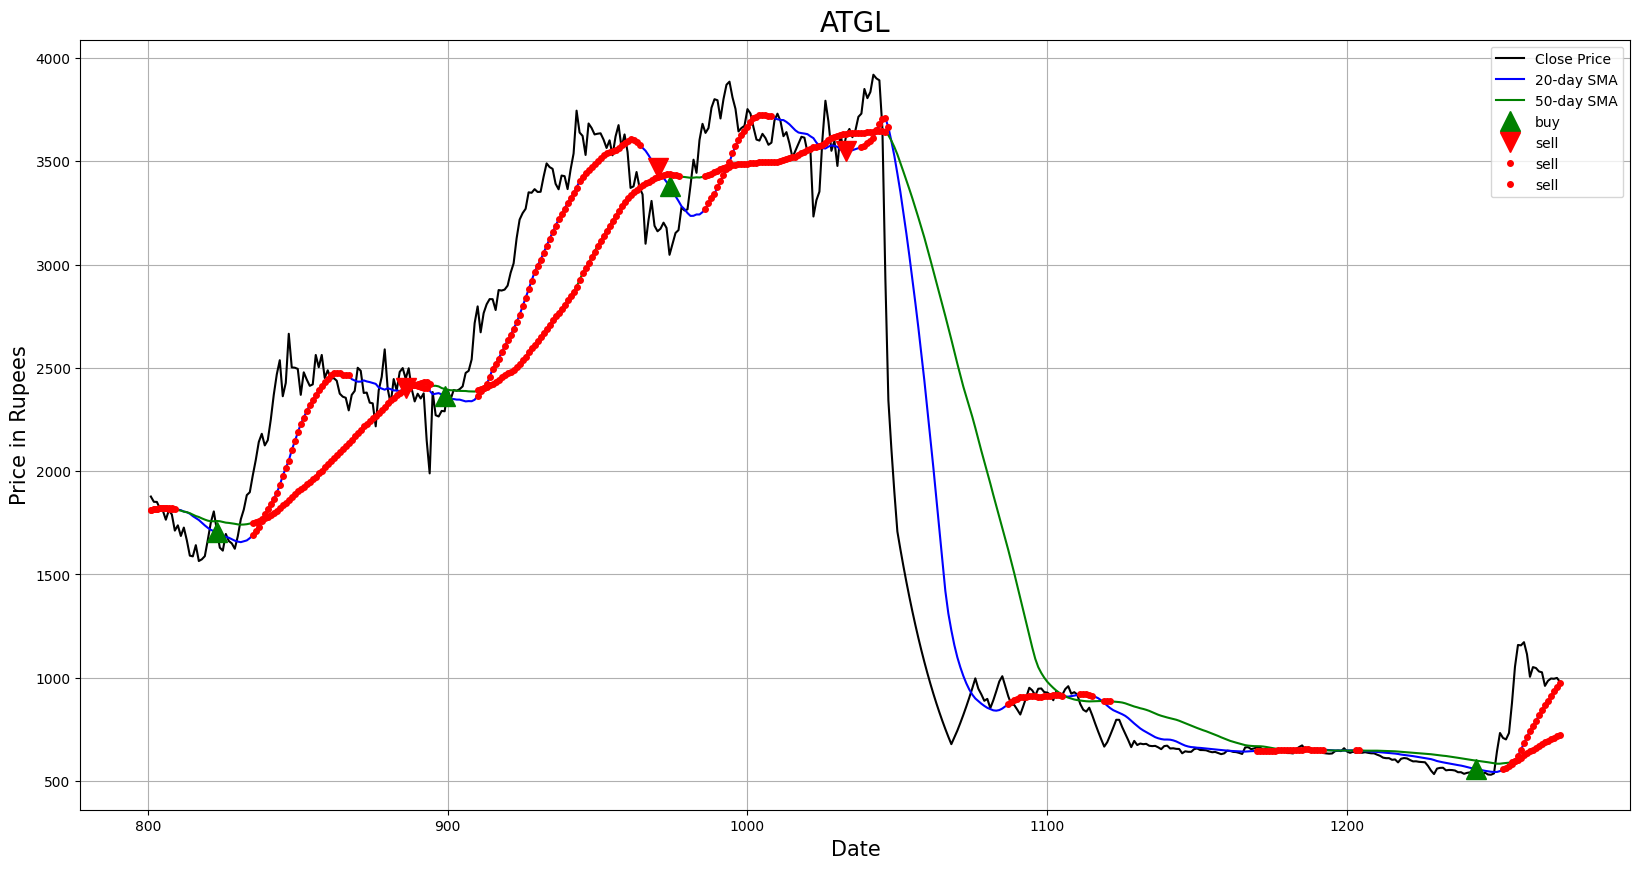

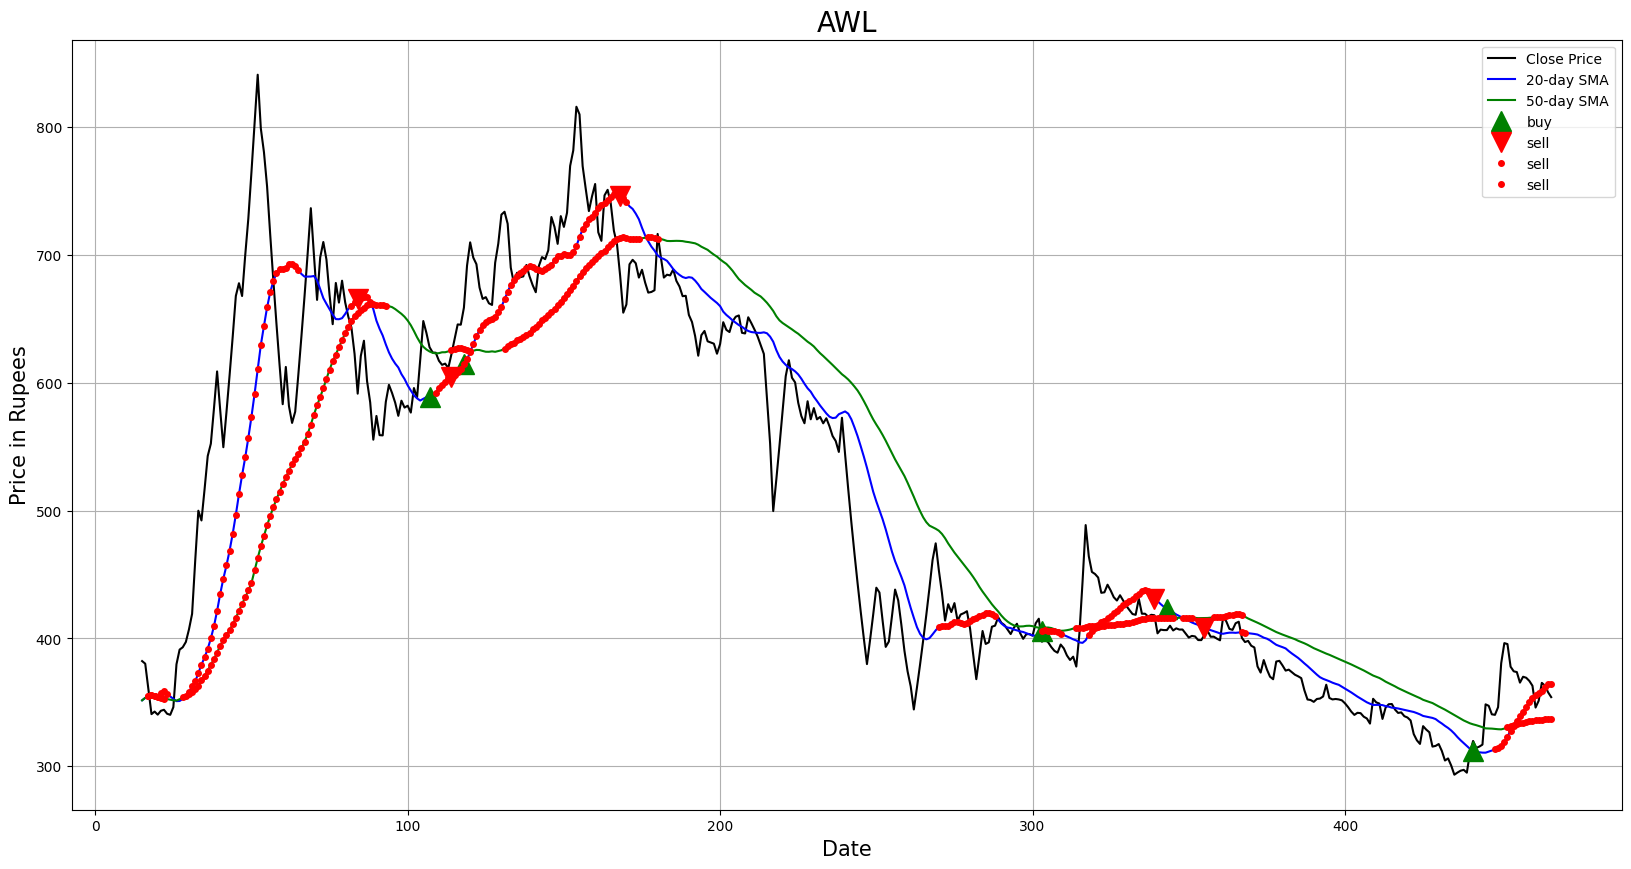

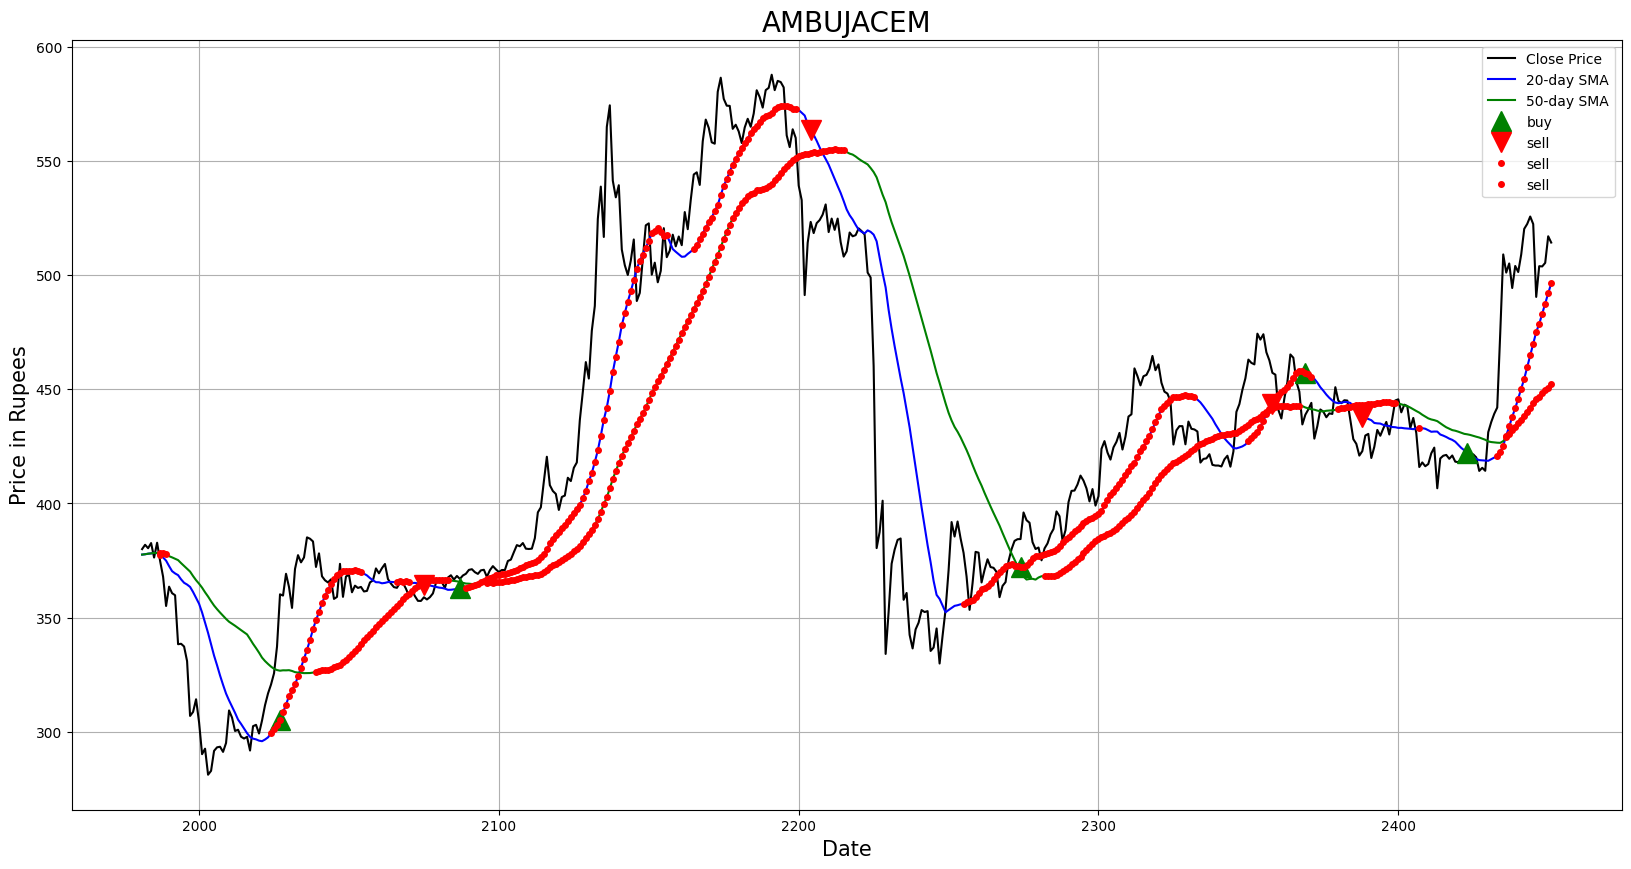

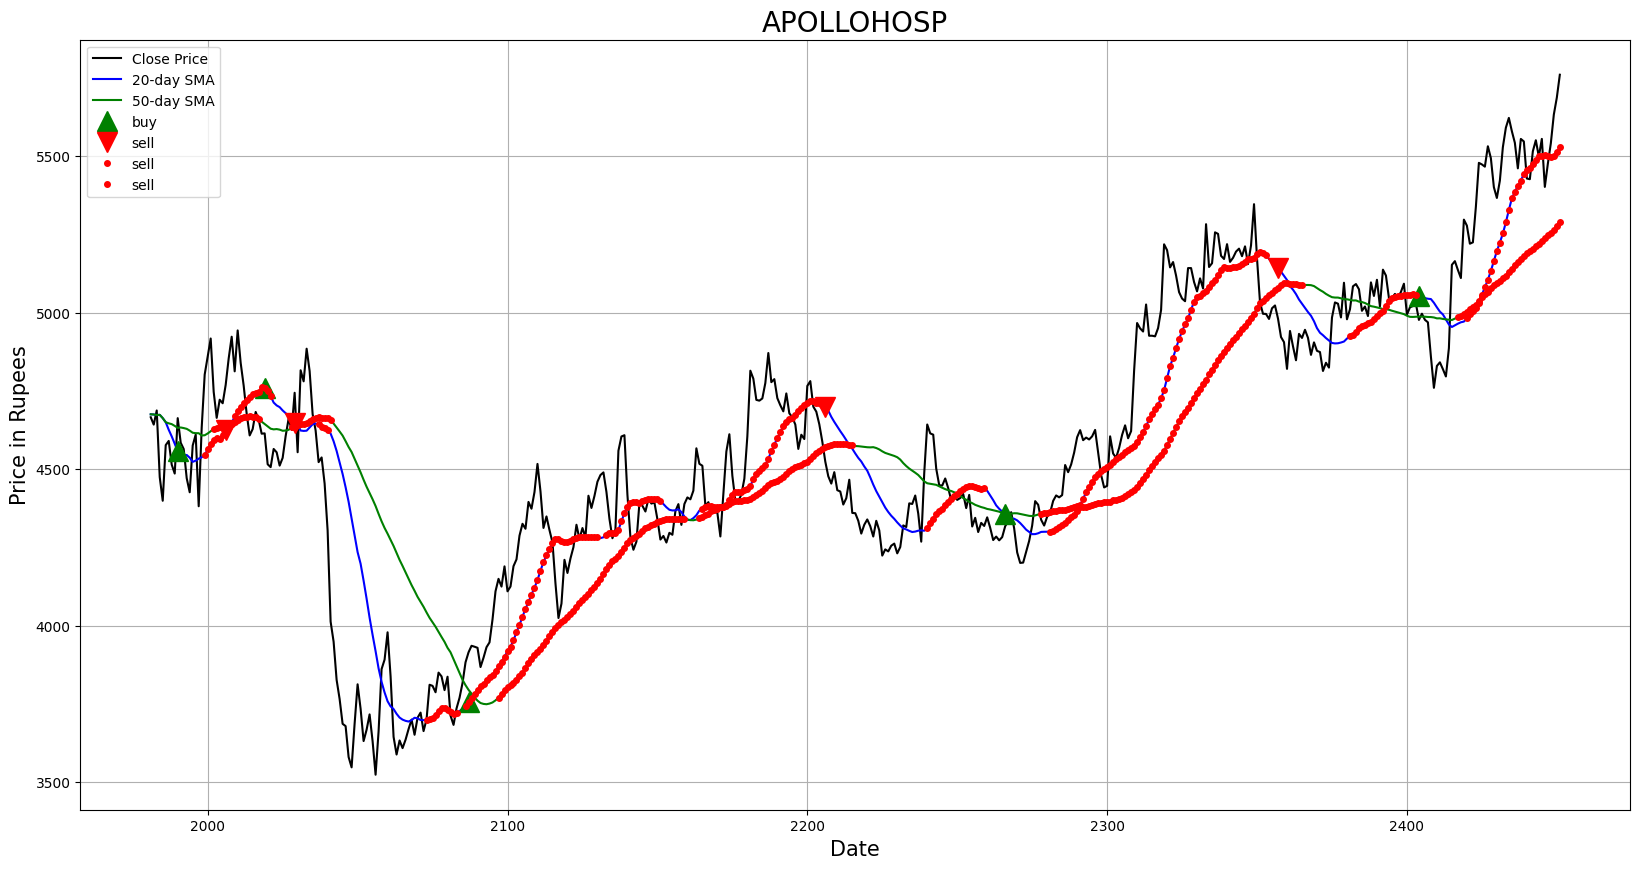

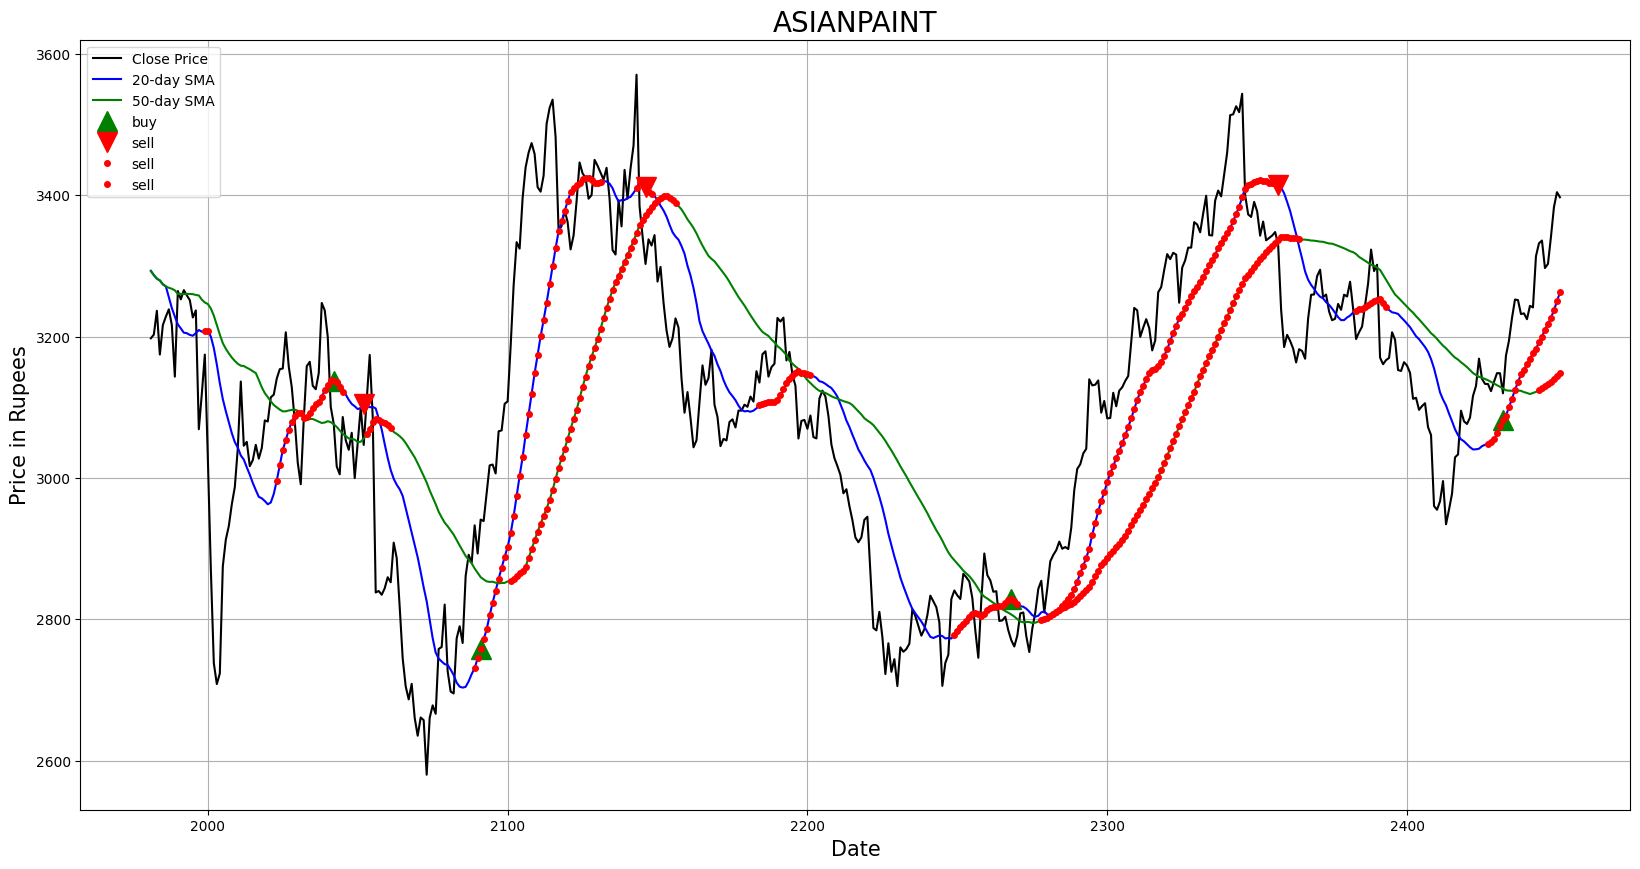

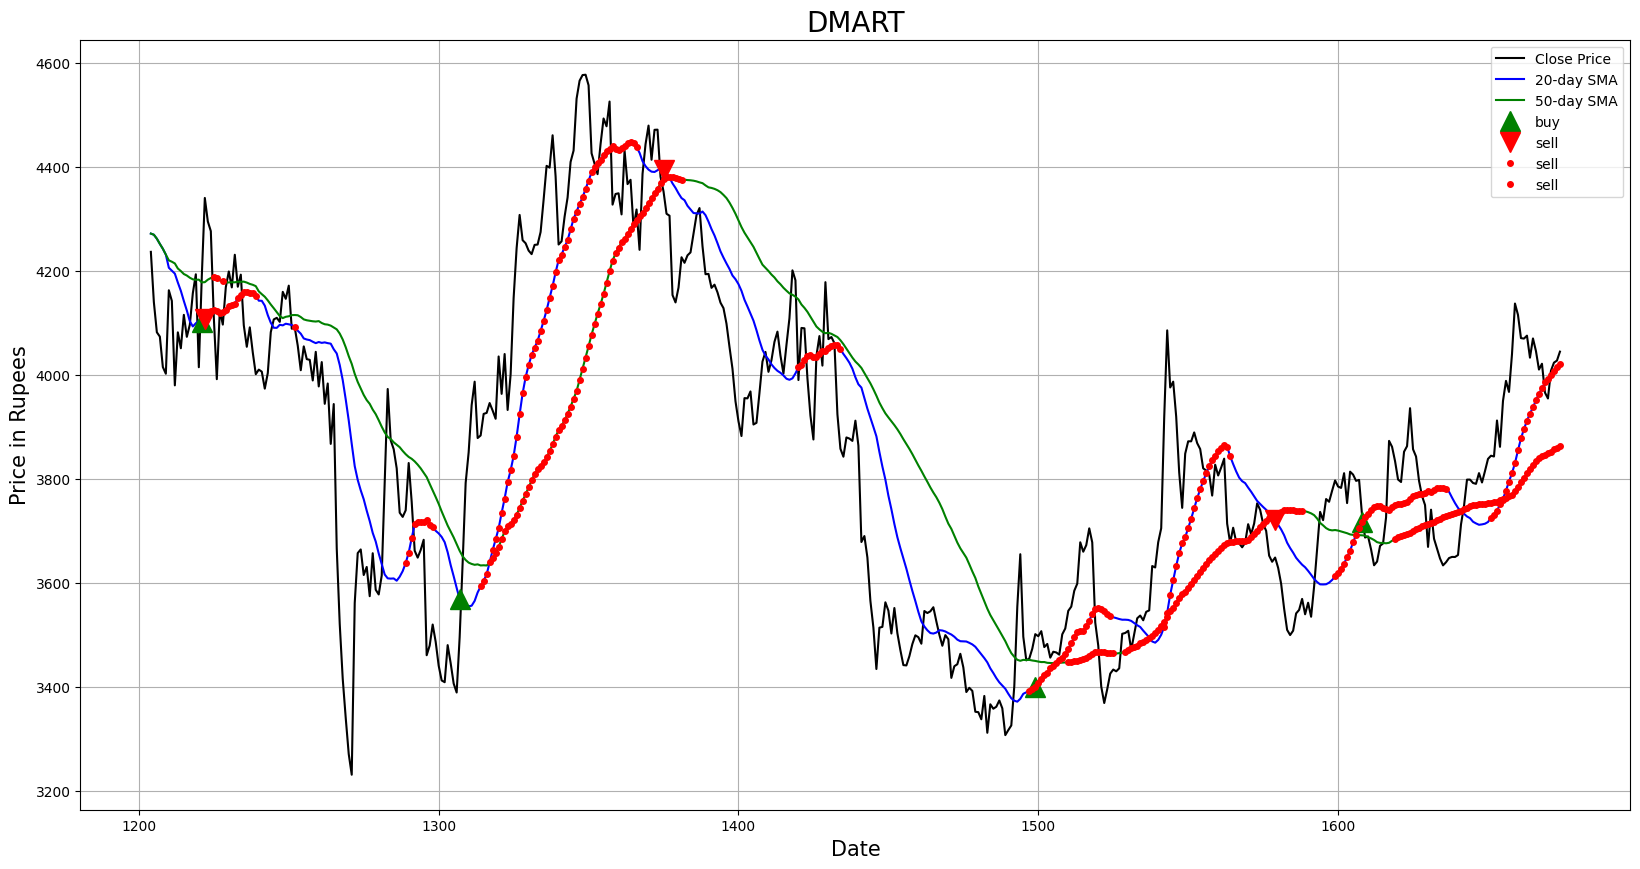

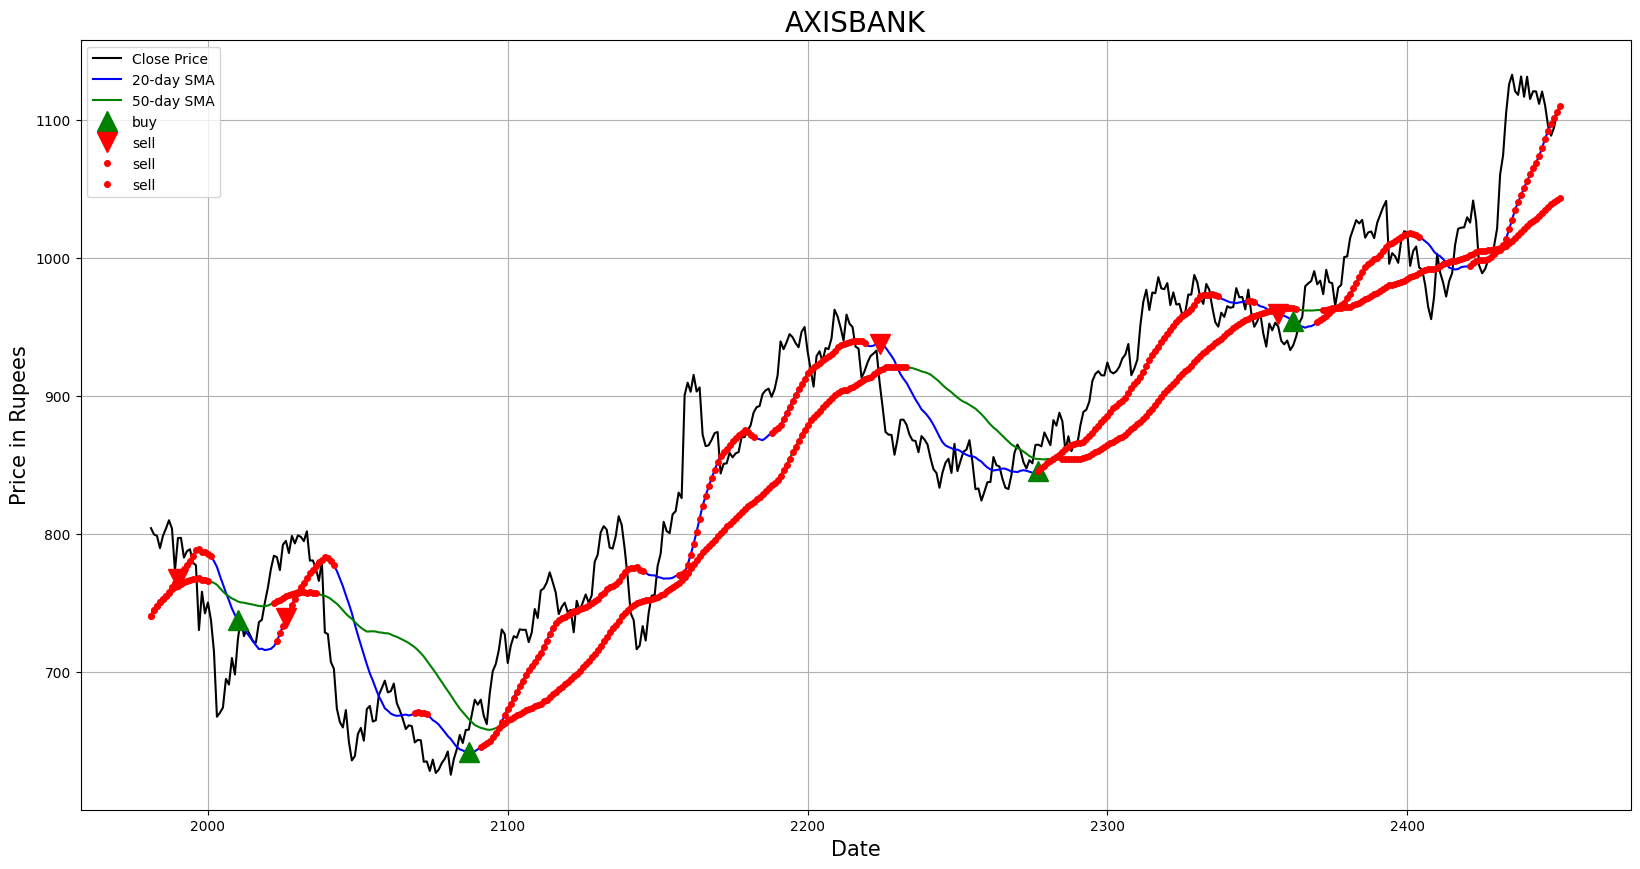

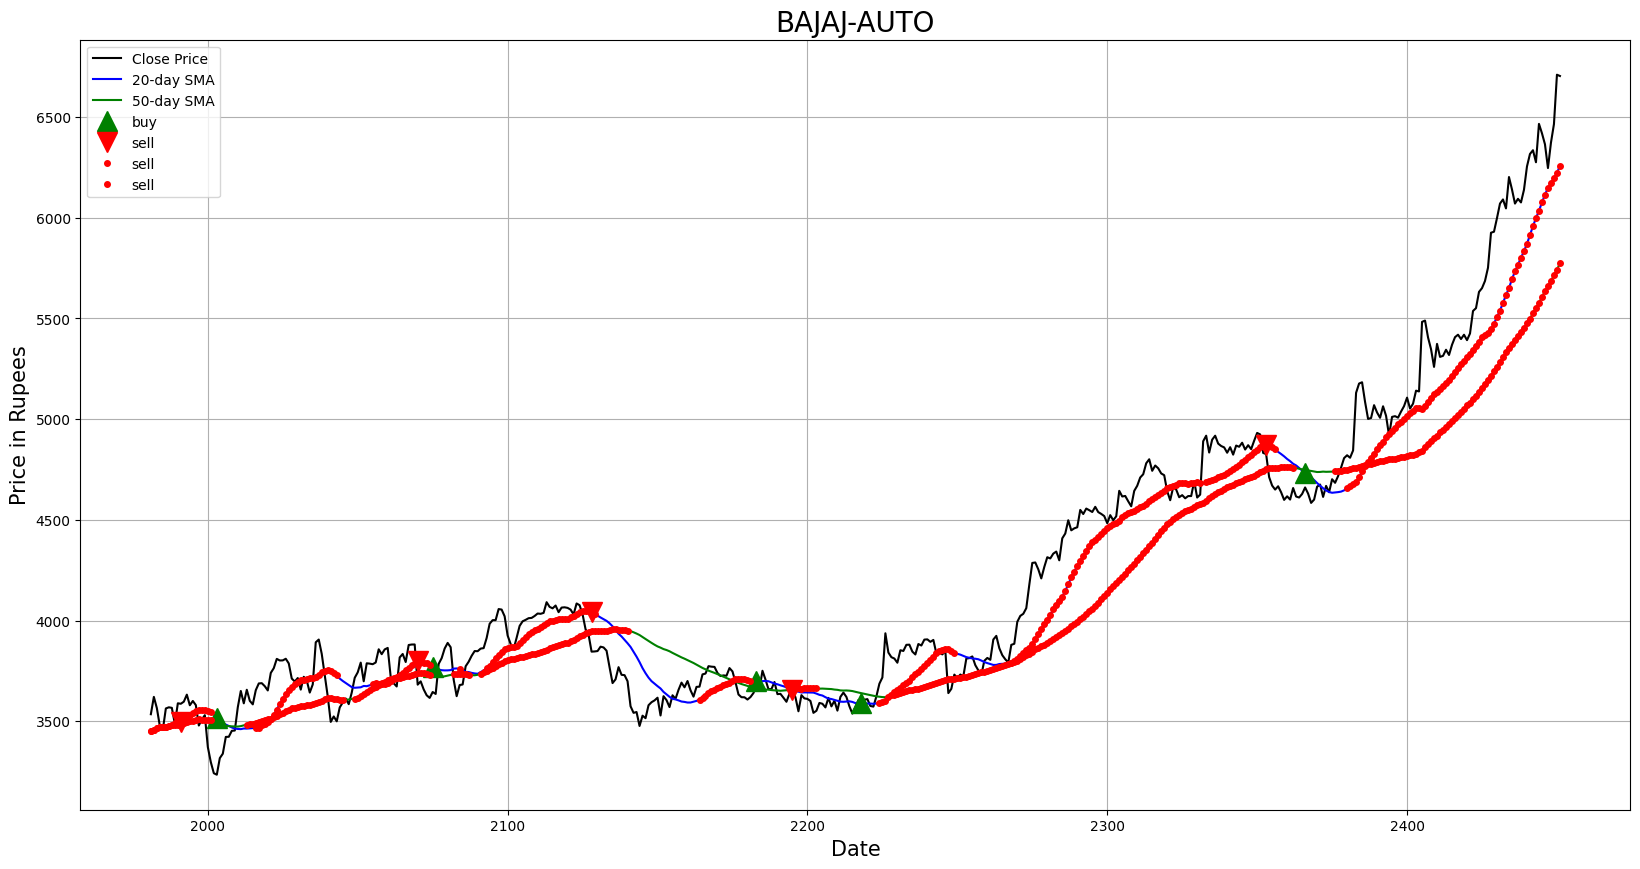

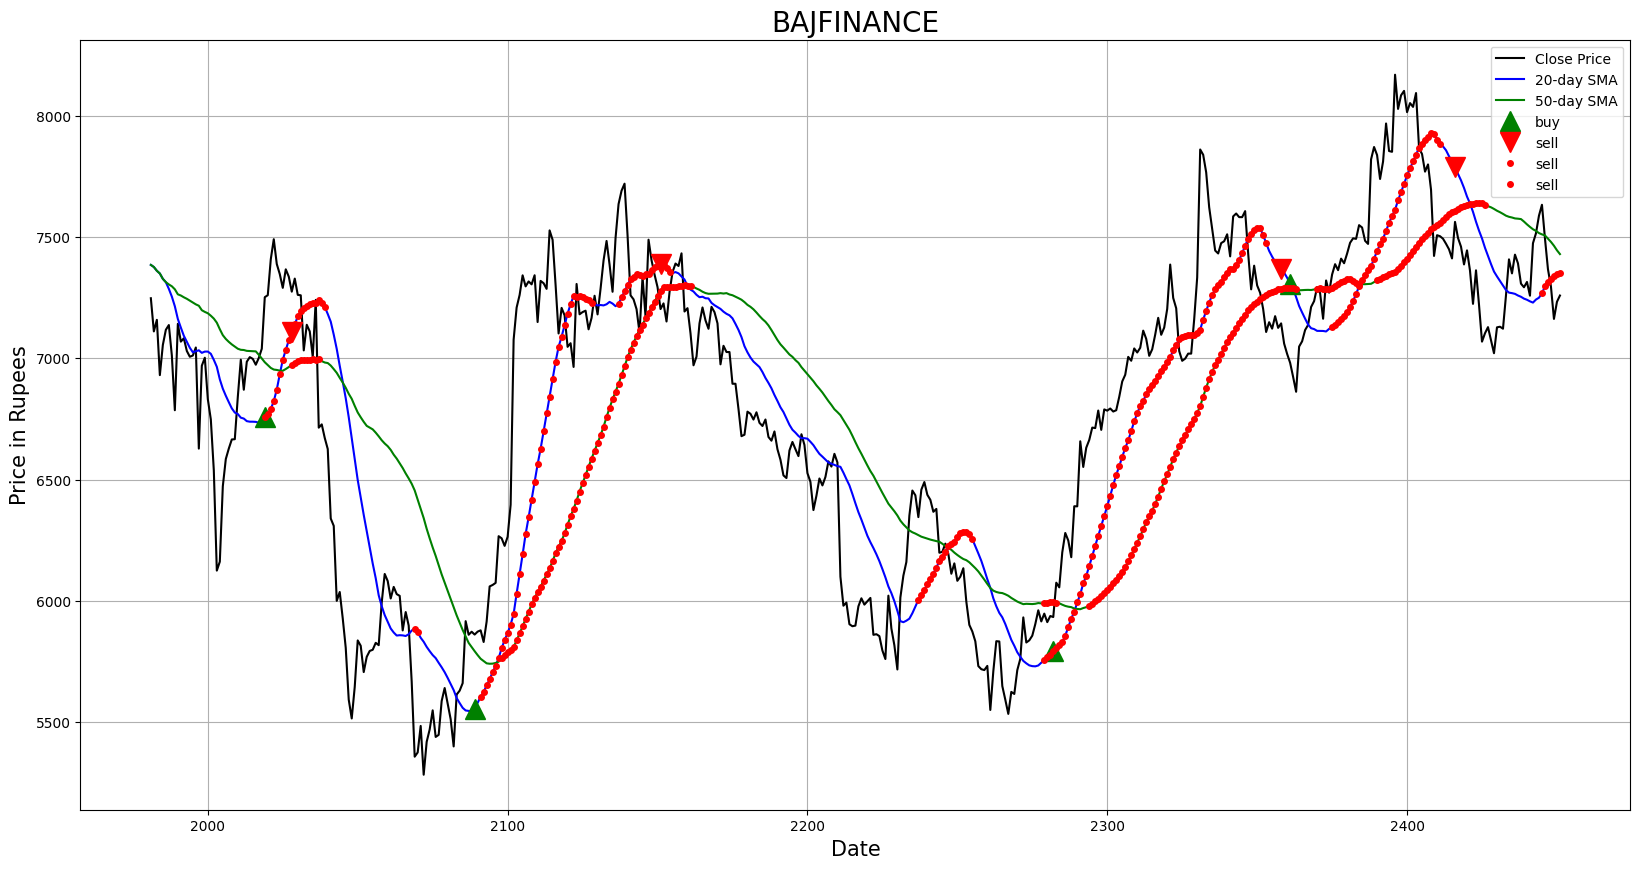

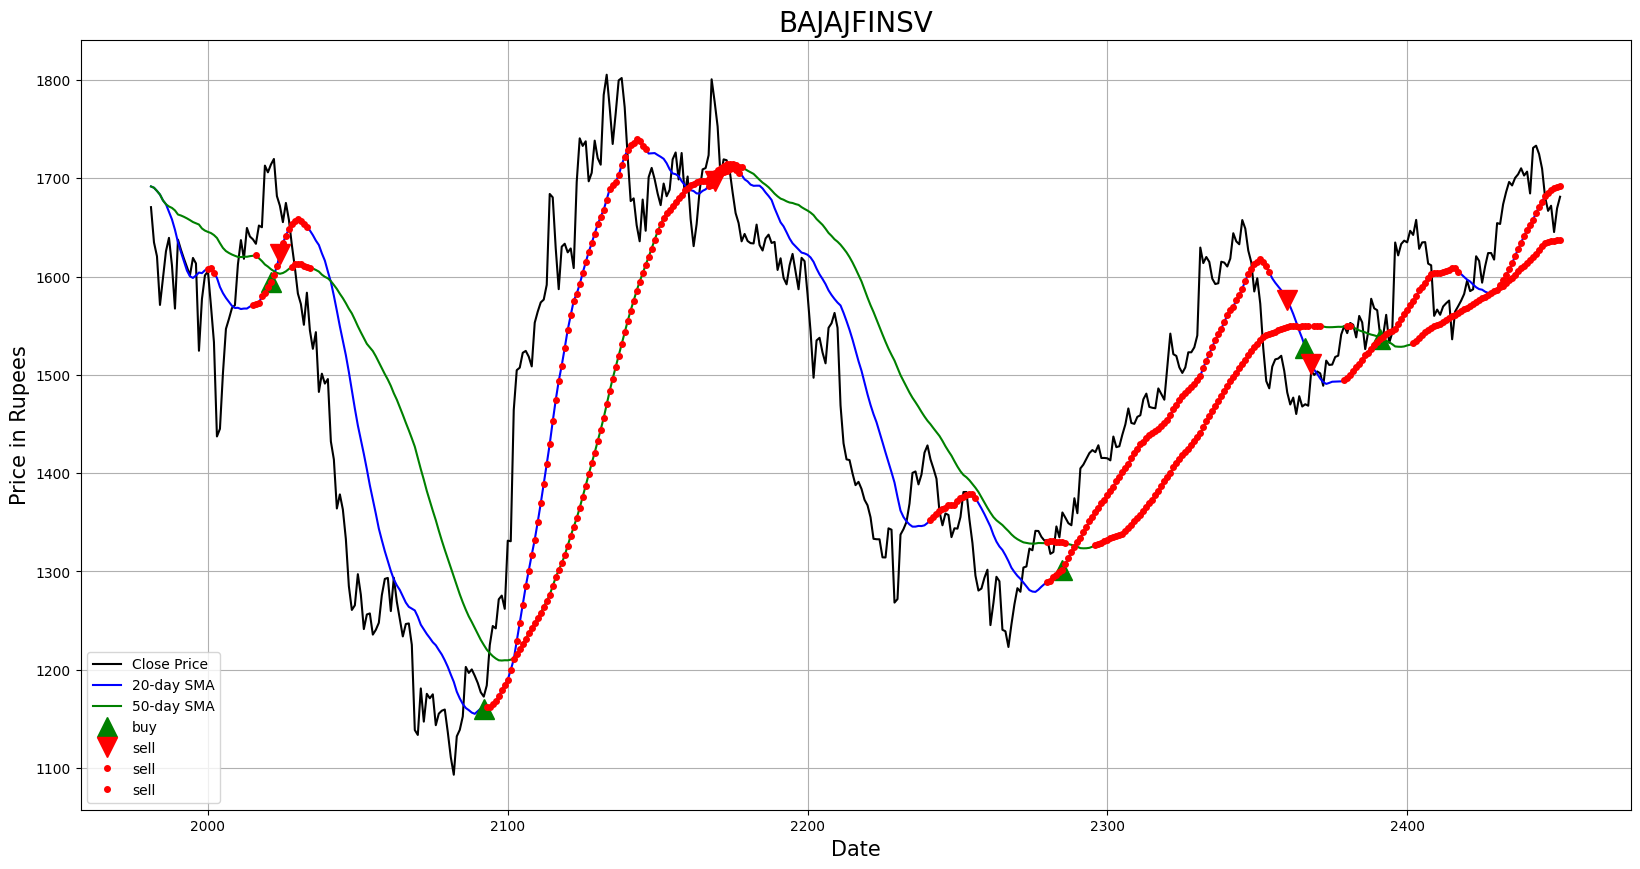

In [ ]:
bt = Backtest()
capital = 500000
stocks = pd.read_csv('./ind_nifty100list.csv')
scripts = stocks["Symbol"]
# scripts=["IEX"]
for stock in scripts[:15]:
    data = GoldenCrossverSignal(stock,500)
    # try :
    #     required_df = data[(data.index >= data[data['Predict'] == 'Buy'].index[0]) & (data.index <= data[data['Predict'] == 'Sell'].index[-1])]
    #     print(len(required_df))
    #     for index, data in required_df.iterrows():
    #         if(data.Predict == 'Buy'):
    #             qty = capital // data.Open
    #             bt.buy(stock, index, data.Open, qty)
    #         else:
    #             bt.sell(index, data.Open, 'Exit Trigger', 0)
    # except :
    #     pass

In [ ]:
bt.stats()


+--------------------------+--------------------+
| Parameters               | Values             |
|--------------------------+--------------------|
| Total Trade Scripts      | 15                 |
| Total Trade              | 901                |
| PNL                      | 1193803.8499999999 |
| Winners                  | 461                |
| Losers                   | 440                |
| Win Ratio                | 51.17%             |
| Total Profit             | 3937412.8          |
| Total Loss               | -2743608.95        |
| Average Loss per Trade   | -6235.47           |
| Average Profit per Trade | 8541.03            |
| Average PNL Per Trade    | 1324.98            |
| Risk Reward              | 1:1.37             |
+--------------------------+--------------------+


## Backtesting Using Library

In [ ]:

def sma_strategy(ticker,period,name,start='2014-4-1', end= '2023-1-1'):
  path = f'./Data/{ticker}.csv'
  # Select data between particular dates
  start_date = pd.to_datetime(start)
  end_date = pd.to_datetime(end)
  price_data = pd.read_csv(path, parse_dates=['Date'], index_col='Date')
  price_data = price_data.loc[(price_data.index >= start_date) & (price_data.index <= end_date)]
  price_data['Prev_Close'] = price_data.Close.shift(1)
  sma = price_data[['Prev_Close']].rolling(period).mean()
  po = price_data[["Open"]]
  sma.rename(columns={"Prev_Close" : "Open"}, inplace=True)
  bt_strategy = bt.Strategy(name, [
      bt.algos.SelectWhere(po>sma),
      bt.algos.WeighEqually(),
      bt.algos.Rebalance(),
  ])

  return bt.Backtest(bt_strategy, po)

def buy_and_hold(ticker, name, start='2014-4-1', end= '2023-1-1'):
  # Get the data
  path = f'./Data/{ticker}.csv'
  # Select data between particular dates
  start_date = pd.to_datetime(start)
  end_date = pd.to_datetime(end)
  price_data = pd.read_csv(path, parse_dates=['Date'], index_col='Date')
  price_data = price_data.loc[(price_data.index >= start_date) & (price_data.index <= end_date)]
  po = price_data[["Open"]]
  # Define the benchmark strategy
  bt_strategy = bt.Strategy(name,[bt.algos.RunOnce(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()])
  # Return the backtest
  return bt.Backtest(bt_strategy, po)

def mean_aversion(ticker,start='2014-4-1',end='2023-4-1'):
  price_data = bt.get(f'{ticker}.NS',start = start, end=end)
  stock_rsi  = talib.RSI(price_data[price_data.columns[0]]).to_frame()
  mean = stock_rsi.mean()
  signal = stock_rsi.copy()
  signal[stock_rsi.isnull()] = 0
  by = mean-0.1*mean
  se=mean+0.2*mean
  signal[stock_rsi < by] = 1
  signal[stock_rsi > se] = -1
  signal[(stock_rsi <= se) & (stock_rsi >= by)] = 0
  buy=0
  for index, sig in signal.iterrows():
    if buy == 0 and sig[0] == -1 :
      index_to_update = pd.to_datetime(index)
      signal.at[index,0] = 0
      continue
    if sig[0] ==1 and buy ==1:
      signal.at[index,0] = 0
      continue
    if sig[0] ==1:
      buy=1
      continue
    if buy == 1 and sig[0] == -1:
      buy = 0
      continue
  signal = signal[(signal.index >= signal[signal[0] == 1].index[0]) & (signal.index <= signal[signal[0] == -1].index[-1])]
  new_columns={0: price_data.columns[0]}

  signal.rename(columns=new_columns, inplace=True)

  bt_strategy = bt.Strategy("RSI",
                            [
                                bt.algos.WeighTarget(signal),
                                bt.algos.Rebalance(),
                            ])
  return bt.Backtest(bt_strategy,price_data)

In [ ]:
buy_and_hold("DMART","sma20",start = "2018-09-24")

In [ ]:

def analyse(ticker,start="2018-09-24"):
  sma20 = sma_strategy(ticker,20,"sma20",start = start)
  sma50 = sma_strategy(ticker,50,"sma50",start = start)
  sma100 = sma_strategy(ticker,100,"sma100",start = start)
  # meanaversion = mean_aversion(ticker,start=start)
  benchmark = buy_and_hold(ticker,"benchmark",start = start)
  bt_results = bt.run(sma20,sma50,sma100,benchmark)
  return bt_results

In [ ]:
result = defaultdict(list)
equity_details = pd.read_csv('./EQUITY_L.csv') # All Details for NSE stocks : Symbol is the required field
for name in list(equity_details.SYMBOL)[:5]:
  try:
    res = analyse(name)
  except Exception as e:
    if e==KeyboardInterrupt:
      break
    print(name)
    continue
  maxstat = res.stats.loc['cagr'].astype(float).idxmax()
  cagr = float(res.stats.loc['cagr',maxstat])
  result[maxstat].append({
      "name": name,
      "cagr":cagr,
  })




In [ ]:
# prompt: save result to disk
import json
with open('results.json', 'w') as f:
    json.dump(result, f)

In [ ]:
for key,val in result.items():
  val.sort(key = lambda x : x["cagr"], reverse=True)
  print(key , " ", val)

benchmark   [{'name': 'IEL', 'cagr': 1711398.246815994}, {'name': 'HYBRIDFIN', 'cagr': 3200.038259534797}, {'name': 'BIKAJI', 'cagr': 12.983822828713322}, {'name': 'FIVESTAR', 'cagr': 9.692074846472014}, {'name': 'HARDWYN', 'cagr': 6.563026367637369}, {'name': 'KRITI', 'cagr': 6.473366242022422}, {'name': 'AXITA', 'cagr': 5.229513657565078}, {'name': 'GOYALALUM', 'cagr': 4.897076972539352}, {'name': 'SATINDLTD', 'cagr': 3.8874972171846984}, {'name': 'HNDFDS', 'cagr': 3.4713315161669085}, {'name': 'ACI', 'cagr': 3.3938739895569876}, {'name': 'MHLXMIRU', 'cagr': 3.295142419220217}, {'name': 'PAVNAIND', 'cagr': 3.181262961731238}, {'name': 'KPIGREEN', 'cagr': 2.8439237729481763}, {'name': 'SBC', 'cagr': 2.70725504481598}, {'name': 'VENUSPIPES', 'cagr': 2.4411609115009565}, {'name': 'DEEPINDS', 'cagr': 2.4019720648774463}, {'name': 'AWL', 'cagr': 2.0489619681396456}, {'name': 'SHAREINDIA', 'cagr': 1.918317980333752}, {'name': 'IWEL', 'cagr': 1.8478918595019618}, {'name': 'SBCL', 'cagr': 1.

## DataPrepare

In [ ]:
startidx = 4
endidx = 20
CustomStrategy = ta.Strategy(
    name="Momo and Volatility",
    description="SMA 20,50,200, BBANDS, RSI, MACD and Volume SMA 20",
    ta=[
        {"kind": "sma", "length": 50},
        {"kind": "sma", "length": 20},
        {"kind": "sma", "length": 7},
        {"kind": "bbands", "length": 20},
        {"kind": "rsi", "length" : 7},
        {"kind": "macd", "fast": 8, "slow": 21},
        # {"kind": "sma", "close": "volume", "length": 20, "prefix": "VOLUME"},
        {"kind": "cdl_pattern" , "name" : ["doji",'belthold', 'engulfing', 'longline', 'shootingstar', "morningstar","hammer", "inside","invertedhammer"]}
    ]
)

def get_data(ticker, start,end):
  path = f'./Data/{ticker}.csv'
  start_date = pd.to_datetime(start)
  end_date = pd.to_datetime(end)
  price_data = pd.read_csv(path, parse_dates=['Date'], index_col='Date')
  price_data = price_data.loc[(price_data.index >= start_date) & (price_data.index <= end_date)]
  return price_data

def add_Ta(ticker,start="2014-04-01", end = "2019-04-01"):
  price_data = get_data(ticker,start,end)
  # Intraday would be our returns
  # price_data.drop(['Volume', ''],axis=1, inplace =True)
  price_data = price_data.astype(float)
  price_data["IntraDayRet"] = price_data['Close'] / price_data['Open']

  #Compute all the indicators
  price_data.ta.strategy(CustomStrategy)
  price_data.drop(['Volume','Adj Close'],axis=1, inplace =True)
  # price_data["Close"] = price_data['Close'].shift(1)
  # price_data["High"] = price_data['High'].shift(1)
  # price_data["Low"] = price_data['Low'].shift(1)
  # Extract 'OPEN' value for broadcasting during division
  open_values = price_data['Open']
  price_data["IntraDayRet"] = (price_data['Close'] / price_data['Open']) - 1

  # Now we shift Close column because at the begin of the day we would be having open not Close so we will compare today open with yesterday close
  price_data.loc[:, 'High':] = price_data.loc[:, 'High':].shift(1)
  # All all the columns in which we will calculate relative value with respect to open
  history_columns = price_data.loc[:, "SMA_50":]
  history_cols = list(history_columns.columns)
  history_cols += ["High","Low"]
  # print(history_cols)
  # # Calculate relative change
  price_data.loc[:, history_cols] = price_data.loc[:, history_cols].div(price_data['Open'], axis=0) - 1

  return price_data

def add_history(price_data):
  CDLcols = history_columns = price_data.iloc[:, endidx:]
  for col in CDLcols.columns:
    for i in range(1,5):
      price_data[f'{col}_{i}'] = price_data[col].shift(i)
  # All all the columns in which we will calculate relative value with respect to open
  history_columns = price_data.iloc[:, startidx:endidx]
  history_cols = list(history_columns.columns)
  history_cols += ["High","Low"]
  for col in history_cols:
    for i in range(1,21):
      price_data[f'{col}_{i}'] = price_data[col].shift(i)
    for i in range(40,100,20):
      price_data[f'{col}_{i}'] = price_data[col].shift(i)
  # print(price_data.columns)
  for i in range(1,21):
    price_data[f'Close_ret_{i}'] = np.where(price_data['Close'].shift(i).notna(), price_data['Close'] / price_data['Close'].shift(i), np.nan)
    price_data[f'Open_ret_{i}'] = np.where(price_data['Close'].shift(i).notna(), price_data['Open'] / price_data['Close'].shift(i), np.nan)

  for i in range(40,100,20):
    price_data[f'Close_ret_{i}'] = np.where(price_data['Close'].shift(i).notna(), price_data['Close'] / price_data['Close'].shift(i), np.nan)
    price_data[f'Open_ret_{i}'] = np.where(price_data['Close'].shift(i).notna(), price_data['Open'] / price_data['Close'].shift(i), np.nan)
  # print(price_data.columns)
  price_data["IntraDayRet_Label"] = price_data['IntraDayRet'].shift(-1)
  return price_data






In [ ]:

import numpy as np
dff = add_Ta("TCS", start = "2008-01-2")
# dff["IntraDayRet_Label"] = dff['IntraDayRet'].shift(-1)
dff = add_history(dff)
dff

,Open,High,Low,Close,IntraDayRet,SMA_50,SMA_20,SMA_7,BBL_20_2.0,BBM_20_2.0,...,Open_ret_19,Close_ret_20,Open_ret_20,Close_ret_40,Open_ret_40,Close_ret_60,Open_ret_60,Close_ret_80,Open_ret_80,IntraDayRet_Label
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-17,1149.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.036967
2014-01-20,1109.474976,0.035625,-0.005814,1106.525024,-0.036967,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.053742
2014-01-21,1167.000000,0.006855,-0.050771,1169.099976,0.053742,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.023008
2014-01-22,1143.550049,0.022802,-0.005247,1140.150024,-0.023008,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005706
2014-01-23,1134.050049,0.012676,-0.001764,1137.025024,-0.005706,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.006900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-25,2007.800049,0.004084,-0.012202,2005.650024,-0.004640,-0.016065,-0.002746,0.002814,-0.036108,-0.002746,...,1.048898,1.047474,1.048596,1.054551,1.055681,1.045426,1.046547,1.086425,1.087590,-0.011729
2019-03-26,1984.000000,0.011996,-0.003427,1984.250000,-0.011729,-0.003281,0.010983,0.013674,-0.016398,0.010983,...,1.030301,1.036595,1.036464,1.057928,1.057795,1.050312,1.050180,1.049729,1.049597,-0.000680
2019-03-27,1994.000000,0.000476,-0.018029,1982.650024,-0.000680,-0.007336,0.007342,0.008250,-0.013585,0.007342,...,1.004458,1.029600,1.035494,1.042649,1.048618,1.038608,1.044553,0.999370,1.005091,-0.013089


In [ ]:
dff['Close'].shift(-1) / dff['Open']

Date
2014-01-17    0.963033
2014-01-20    1.053742
2014-01-21    0.976992
2014-01-22    0.994294
2014-01-23    0.993100
                ...   
2019-03-25    0.988271
2019-03-26    0.999320
2019-03-27    0.986911
2019-03-28    1.010253
2019-04-01         NaN
Length: 1279, dtype: float64

In [ ]:
dff['IntraDayRet']

Date
2014-01-17         NaN
2014-01-20    0.000868
2014-01-21    0.000903
2014-01-22    0.000854
2014-01-23    0.000877
                ...   
2019-03-25    0.000496
2019-03-26    0.000498
2019-03-27    0.000501
2019-03-28    0.000498
2019-04-01    0.000503
Name: IntraDayRet, Length: 1279, dtype: float64

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# df = dff.dropna()
correlation_matrix = dff.corr()['IntraDayRet_Label']

# Set up the matplotlib figure
# plt.figure(figsize=(120, 100))

# Plot the heatmap using seaborn
# sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0, annot=False)
# correlation_matrix.drop('IntraDayRet').plot(kind='bar', color='blue')


In [ ]:
high_correlation_columns = correlation_matrix[correlation_matrix.abs() > 0.7].index
print(high_correlation_columns)
print(correlation_matrix.to_string())

Index(['IntraDayRet_Label'], dtype='object')
Open                   -0.034370
High                   -0.035024
Low                     0.034065
Close                  -0.035244
IntraDayRet             0.008918
SMA_50                  0.061503
SMA_20                  0.021770
SMA_7                  -0.000808
BBL_20_2.0              0.021627
BBM_20_2.0              0.021770
BBU_20_2.0              0.015534
BBB_20_2.0              0.014554
BBP_20_2.0              0.003421
RSI_7                   0.015125
MACD_8_21_9            -0.050958
MACDh_8_21_9            0.022734
MACDs_8_21_9           -0.069491
CDL_DOJI_10_0.1         0.011202
CDL_BELTHOLD            0.005368
CDL_ENGULFING           0.045731
CDL_LONGLINE            0.040485
CDL_SHOOTINGSTAR       -0.011899
CDL_MORNINGSTAR        -0.019434
CDL_HAMMER             -0.026132
CDL_INSIDE              0.003274
CDL_INVERTEDHAMMER      0.013368
CDL_LONGLINE_1         -0.009053
CDL_LONGLINE_2          0.021648
CDL_LONGLINE_3         -0.05181

In [ ]:
    df

,Open,High,Low,Close,IntraDayRet,SMA_50,SMA_20,SMA_7,BBL_20_2.0,BBM_20_2.0,...,CDL_DOJI_10_0.1,CDL_BELTHOLD,CDL_ENGULFING,CDL_LONGLINE,CDL_SHOOTINGSTAR,CDL_MORNINGSTAR,CDL_HAMMER,CDL_INSIDE,CDL_INVERTEDHAMMER,IntraDayRet_Label
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-01,205.125046,0.012980,-0.015539,203.700043,-1.000079,0.035411,0.025727,0.011674,-0.030366,0.025727,...,-1.000000,-1.000000,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.999882
2014-04-02,211.687546,-0.002657,-0.031089,210.393799,-0.999882,0.003609,-0.008273,-0.021498,-0.058752,-0.008273,...,-1.000000,-0.527606,-1.0,100.0,0.0,0.0,0.0,0.0,0.0,-0.999988
2014-04-03,211.875046,0.013274,-0.010619,212.212555,-0.999988,0.002467,-0.011124,-0.021580,-0.056366,-0.011124,...,-0.528024,-1.000000,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.000034
2014-04-04,211.875046,0.005398,-0.013009,210.356308,-1.000034,0.002092,-0.013739,-0.018432,-0.051017,-0.013739,...,-1.000000,-1.000000,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.000101
2014-04-07,207.375046,0.028843,-0.002803,207.525055,-1.000101,0.022949,0.004819,0.004895,-0.025665,0.004819,...,-1.000000,-1.000000,-1.0,-100.0,0.0,0.0,0.0,0.0,0.0,-0.999967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-22,262.450012,0.002096,-0.015432,261.549988,-0.999954,0.019998,0.031770,-0.011431,-0.055469,0.031770,...,-1.000000,-1.000000,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.000028
2019-03-25,262.000000,0.006679,-0.013359,260.549988,-1.000028,0.023001,0.029993,-0.010169,-0.057689,0.029993,...,-1.000000,-1.000000,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.000083
2019-03-26,257.100006,0.019059,-0.004279,256.500000,-1.000083,0.043257,0.044876,0.007918,-0.044924,0.044876,...,-1.000000,-1.388954,-1.0,-100.0,0.0,0.0,0.0,0.0,0.0,-1.000032


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Separate features and target column
features = df.iloc[:, :-1]

# Standardize features (scaling)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Create a DataFrame with scaled features and the target column
df_scaled = pd.DataFrame(scaled_features, columns=features.columns)
df_scaled['IntraDayRet_Label'] = df['IntraDayRet_Label'].values

# Display the DataFrame with scaled features
# print("\nDataFrame with scaled features:")
# print(df_scaled)

# Compute the correlation matrix
correlation_matrix = df_scaled.corr()

# Display the correlation of each feature with the target column
correlation_with_target = correlation_matrix['IntraDayRet_Label']
high_correlation_columns = correlation_with_target[correlation_with_target.abs() > 0.1].index
high_correlation_columns

Index(['High', 'Low', 'IntraDayRet_Label'], dtype='object')

In [ ]:
print(correlation_with_target.to_string())

Open                 -0.047679
High                  0.152206
Low                   0.188251
Close                -0.032291
IntraDayRet          -0.035174
SMA_50                0.033953
SMA_20                0.054235
SMA_7                 0.098103
BBL_20_2.0            0.057763
BBM_20_2.0            0.054235
BBU_20_2.0            0.035894
BBB_20_2.0           -0.008491
BBP_20_2.0           -0.016265
RSI_7                -0.010636
MACD_8_21_9          -0.000952
MACDh_8_21_9         -0.009631
MACDs_8_21_9          0.002986
CDL_DOJI_10_0.1      -0.008656
CDL_BELTHOLD          0.005727
CDL_ENGULFING        -0.047070
CDL_LONGLINE          0.010840
CDL_SHOOTINGSTAR      0.027350
CDL_MORNINGSTAR       0.009491
CDL_HAMMER            0.015423
CDL_INSIDE            0.005463
CDL_INVERTEDHAMMER   -0.019024
IntraDayRet_Label     1.000000


In [ ]:
df

,Open,High,Low,Close,IntraDayRet,SMA_50,SMA_20,SMA_7,BBL_20_2.0,BBM_20_2.0,...,Open_ret_19,Close_ret_20,Open_ret_20,Close_ret_40,Open_ret_40,Close_ret_60,Open_ret_60,Close_ret_80,Open_ret_80,IntraDayRet_Label
Date,,,,,,,,,,,,,,,,,,,,,
2014-07-28,207.056305,0.005162,-0.040116,206.643799,-0.999816,-0.042834,-0.006176,0.005653,-0.045289,-0.006176,...,1.010523,1.009341,1.011356,1.088601,1.090774,1.042668,1.044749,1.014451,1.016476,-0.999958
2014-07-30,208.837555,0.003412,-0.021368,208.893799,-0.999958,-0.048305,-0.013696,0.002129,-0.052954,-0.013696,...,1.034746,1.019491,1.019217,1.116109,1.115808,1.069707,1.069419,0.992871,0.992603,-1.000054
2014-07-31,206.268799,0.012817,-0.001909,206.531296,-1.000054,-0.034413,-0.000273,0.015570,-0.038938,-0.000273,...,1.017010,1.023318,1.022018,1.114427,1.113011,1.069729,1.068369,0.973228,0.971991,-1.000051
2014-08-01,204.000046,0.012868,-0.005423,204.150055,-1.000051,-0.021789,0.011172,0.026720,-0.027469,0.011172,...,0.979298,1.006564,1.005824,1.106392,1.105579,1.075677,1.074886,0.970496,0.969783,-1.000074
2014-08-04,201.075043,0.018557,-0.002238,201.000046,-1.000074,-0.005600,0.024063,0.035594,-0.016447,0.024063,...,0.980704,0.964896,0.965257,1.069967,1.070366,1.049026,1.049418,0.968558,0.968919,-0.999890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-22,262.450012,0.002096,-0.015432,261.549988,-0.999954,0.019998,0.031770,-0.011431,-0.055469,0.031770,...,0.940175,0.959508,0.962810,1.032366,1.035918,1.082686,1.086412,1.135569,1.139477,-1.000028
2019-03-25,262.000000,0.006679,-0.013359,260.549988,-1.000028,0.023001,0.029993,-0.010169,-0.057689,0.029993,...,0.932675,0.933369,0.938563,1.002597,1.008177,1.063361,1.069278,1.090909,1.096980,-1.000083
2019-03-26,257.100006,0.019059,-0.004279,256.500000,-1.000083,0.043257,0.044876,0.007918,-0.044924,0.044876,...,0.905082,0.913095,0.915231,0.972834,0.975110,1.048597,1.051050,1.095978,1.098542,-1.000032


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint("Naharspining_gru.wt",
                    monitor="val_loss", mode="min",
                    save_best_only=True, verbose=1)

model.fit(trainX,trainY,epochs=50, batch_size=8 , validation_data=(validX, validY), callbacks=[early_stopping,checkpoint])
model.load_weights("Naharspining_gru.wt")
test_predict = model.predict(testX)

Epoch 1/50
492/493 [============================>.] - ETA: 0s - loss: 4.6783e-04
Epoch 1: val_loss improved from inf to 0.00016, saving model to Naharspining_gru.wt
493/493 [==============================] - 28s 57ms/step - loss: 4.6806e-04 - val_loss: 1.6355e-04
Epoch 2/50
493/493 [==============================] - ETA: 0s - loss: 5.0327e-04
Epoch 2: val_loss improved from 0.00016 to 0.00003, saving model to Naharspining_gru.wt
493/493 [==============================] - 27s 55ms/step - loss: 5.0327e-04 - val_loss: 3.1919e-05
Epoch 3/50
491/493 [============================>.] - ETA: 0s - loss: 4.8557e-04
Epoch 3: val_loss did not improve from 0.00003
493/493 [==============================] - 10s 21ms/step - loss: 4.8476e-04 - val_loss: 3.2267e-05
Epoch 4/50
493/493 [==============================] - ETA: 0s - loss: 4.6937e-04
Epoch 4: val_loss did not improve from 0.00003
493/493 [==============================] - 10s 19ms/step - loss: 4.6937e-04 - val_loss: 8.0016e-05
Epoch 5/50
492

In [ ]:
test_predict = model.predict(validX).reshape(-1)
# test_predict = scaler.inverse_transform(np.tile(test_predict, df_for_training_df.shape[1]))[:,0]
# valid_pred = model.predict(validX)
# y_test_copy = np.tile(valid_pred, df_for_training_df.shape[1])
y_test_scaled = validY.reshape(-1)


16/16 [==============================] - 0s 4ms/step


In [ ]:
# test_predict = model.predict(testX)
# test_predict = scaler.inverse_transform(np.tile(test_predict, df_for_training_df.shape[1]))[:,0]
# y_test_copy = np.tile(testY, df_for_training_df.shape[1]) #np.repeat(testY, df_for_training_df.shape[1], axis=-1)
# y_test_scaled = scaler.inverse_transform(y_test_copy)[:,0]

16/16 [==============================] - 0s 11ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_scaled, test_predict)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Display the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 29.381037959827605
Root Mean Squared Error (RMSE): 5.420427839186461
